In [1]:
import mlxtend
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pandas_ml
from pandas_ml import ConfusionMatrix

In [2]:
import os
from sklearn.utils import shuffle
import glob
import sys
################### DATASET HANDLING ####################
DATASET_PATH = "/home/dic/jupyter/train_data_new2" #change the path to your dataset folder here

def parseDataset():
 
    #we use subfolders as class labels
    classes = [folder for folder in sorted(os.listdir(DATASET_PATH))]
 
    #now we enlist all image paths
    images = []
    for c in classes:
        images += ([os.path.join(DATASET_PATH, c, path) for path in os.listdir(os.path.join(DATASET_PATH, c))])
    #print(images)
    #shuffle image paths
    images = shuffle(images, random_state=80)
 
    #we want to use a 15% validation split
    total_len=len(images)
    print("total:",total_len)
    vsplit = int(len(images) * 0.60) #=40
    print("vsplit:",vsplit)
    
    tsplit= int(total_len-vsplit)
    print("tsplit:",tsplit)
    
    gsplit=int(tsplit/2)
    print(gsplit)
    msplit=int(vsplit+gsplit)
    
    
    train = images[:vsplit] #everything except the last vsplit items in the array 
    val = images[vsplit:msplit]  #only last vsplit items from the array
    test=images[msplit:]
    #show some stats
    print ("CLASS LABELS:", classes)
    print ("TRAINING IMAGES:", len(train))
    print ("VALIDATION IMAGES:", len(val))
    print ("TEST IMAGES:", len(test))
    return classes, train, val,test
 
#parse dataset
CLASSES, TRAIN, VAL,TEST = parseDataset()


total: 107693
vsplit: 64615
tsplit: 43078
21539
CLASS LABELS: ['ACEP', 'CEP', 'DSCT', 'ECL', 'LPV', 'RRLYR', 'T2CEP']
TRAINING IMAGES: 64615
VALIDATION IMAGES: 21539
TEST IMAGES: 21539


In [3]:
import lasagne
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh

In [4]:
import os
import time
from sklearn.utils import shuffle

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools

from lasagne import random as lasagne_random
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
from lasagne import objectives
from lasagne import updates

import theano
import theano.tensor as T

import warnings
warnings.filterwarnings("ignore")


In [5]:
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
 
################## BUILDING THE MODEL ###################
def buildModel():
    #this is our input layer with the inputs (None, dimensions, width, height)
    l_input = layers.InputLayer((None, 3, 22, 23))
    
    l_conv1 = layers.Conv2DLayer(l_input, num_filters=64, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_pool = layers.MaxPool2DLayer(l_conv1, pool_size=2)
    
    l_drop1= layers.DropoutLayer(l_pool,  p=0.1)
    
    #l_dense1 = layers.DenseLayer(l_drop1, num_units=128)
    
    l_conv2 = layers.Conv2DLayer(l_drop1, num_filters=128, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
    #l_conv3 = layers.Conv2DLayer(l_conv2, num_filters=256, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_dense2 = layers.DenseLayer(l_conv2, num_units=256)
    
    l_drop2= layers.DropoutLayer(l_dense2,  p=0.25)
    
    l_dense2 = layers.DenseLayer(l_drop2, num_units=256)
    
    l_output = layers.DenseLayer(l_dense2, num_units=7, nonlinearity=lasagne.nonlinearities.softmax)
    
    #let's see how many params our net has
    print ("MODEL HAS", layers.count_params(l_output), "PARAMS")
   
    #we return the layer stack as our network by returning the last layer
    return l_output


NET = buildModel()


MODEL HAS 1454215 PARAMS


In [6]:
from lasagne import objectives
 
import theano
import theano.tensor as T
 
#################### LOSS FUNCTION ######################
def calc_loss(prediction, targets):
 
    #categorical crossentropy is the best choice for a multi-class softmax output
    l = T.mean(objectives.categorical_crossentropy(prediction, targets))
    
    return l
 
#theano variable for the class targets
#this is the output vector the net should predict
targets = T.matrix('targets', dtype=theano.config.floatX)
 
#get the network output
prediction = layers.get_output(NET)
 
#calculate the loss
loss = calc_loss(prediction, targets)

In [7]:
################# ACCURACY FUNCTION #####################
def calc_accuracy(prediction, targets):
 
    #we can use the lasagne objective categorical_accuracy to determine the top1 accuracy
    a = T.mean(objectives.categorical_accuracy(prediction, targets, top_k=1))
    
    return a
 
accuracy = calc_accuracy(prediction, targets)

In [8]:
from lasagne import updates
 
####################### UPDATES #########################
#get all trainable parameters (weights) of our net
params = layers.get_all_params(NET, trainable=True)
 
#we use the adam update
#it changes params based on our loss function with the learning rate
param_updates = updates.adam(loss, params, learning_rate=0.0002)

In [9]:
import theano
#################### TRAIN FUNCTION ######################
#the theano train functions takes images and class targets as input
#it updates the parameters of the net and returns the current loss as float value
#compiling theano functions may take a while, you might want to get a coffee now...
print ("COMPILING THEANO TRAIN FUNCTION...",)
train_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], loss, updates=param_updates)
print ("DONE!")
 
################# PREDICTION FUNCTION ####################
#we need the prediction function to calculate the validation accuracy
#this way we can test the net after training
#first we need to get the net output
net_output = layers.get_output(NET)
 
#now we compile another theano function; this may take a while, too
print ("COMPILING THEANO TEST FUNCTION...",)
test_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], [net_output, loss, accuracy])
print ("DONE!")

COMPILING THEANO TRAIN FUNCTION...
DONE!
COMPILING THEANO TEST FUNCTION...
DONE!


In [10]:
import cv2
import numpy as np
 
#################### BATCH HANDLING #####################
def loadImageAndTarget(path):
    #print(path)
    #here we open the image and scale it to 64x64 pixels
    img = cv2.imread(path)
    
    #print(path)
    img = cv2.resize(img, (22, 23))
    
    
    #OpenCV uses BGR instead of RGB, but for now we can ignore that
    #our image has the shape (64, 64, 3) but we need it to be (3, 64, 64)
    img = np.transpose(img, (2, 1, 0))
    
    #we want to use subfolders as class labels
    label = path.split(os.sep[-1])[-2]
    #print(label)
 
    #we need to get the index of our label from CLASSES
    index = CLASSES.index(label)
 
    #allocate array for target
    target = np.zeros((7), dtype='float32')
 
    #we set our target array = 1.0 at our label index, all other entries remain zero
    #Example: if label = dog and dog has index 2 in CLASSES, target looks like: [0.0, 0.0, 1.0, 0.0, 0.0]
    target[index] = 1.0
 
    #we need a 4D-vector for our image and a 2D-vector for our targets
    #we can adjust array dimension with reshape
    img = img.reshape(-1, 3, 22, 23)
    target = target.reshape(-1, 7)
 
    return img, target

In [11]:
#a reasonable size for one batch is 128
BATCH_SIZE = 300
def getDatasetChunk(split):
 
    #get batch-sized chunks of image paths
    for i in range(0, len(split), BATCH_SIZE):
        yield split[i:i+BATCH_SIZE]
        
def getNextImageBatch(split=TRAIN):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_b = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_b = np.zeros((BATCH_SIZE, 7), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        ib = 0
        for path in chunk:
            #load image data and class label from path
            x, y = loadImageAndTarget(path)
 
            #pack into batch array
            x_b[ib] = x
            y_b[ib] = y
            ib += 1
 
        #instead of return, we use yield
        yield x_b[:len(chunk)], y_b[:len(chunk)]

In [12]:

        
def getNextImageBatch1(split=TEST):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_T = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_T = np.zeros((BATCH_SIZE, 7), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        iT = 0
        for path in chunk:
            #load image data and class label from path
            x1, y1 = loadImageAndTarget(path)
 
            #pack into batch array
            x_T[iT] = x1
            y_T[iT] = y1
            iT += 1
 
        #instead of return, we use yield
        yield x_T[:len(chunk)], y_T[:len(chunk)]

In [13]:
cmatrix = []
def clearConfusionMatrix():

    global cmatrix

    #allocate empty matrix of size 5x5 (for our 5 classes)
    cmatrix = np.zeros((len(CLASSES), len(CLASSES)), dtype='int32')
    
    
def updateConfusionMatrix(t, p):
    
    global cmatrix
    cmatrix += confusion_matrix(np.argmax(t, axis=1), np.argmax(p, axis=1))
    
def showConfusionMatrix():

    #new figure
    plt.figure(1)
    plt.clf()

    #show matrix
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    #tick marks
    tick_marks = np.arange(len(CLASSES))
    plt.xticks(tick_marks, CLASSES)
    plt.yticks(tick_marks, CLASSES)

    #labels
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, cmatrix[i, j], 
                 horizontalalignment="center",
                 color="white" if cmatrix[i, j] > thresh else "black")

    #axes labels
    plt.ylabel('Target label')
    plt.xlabel('Predicted label')

    #show
    plt.show()
    plt.pause(0.5)   


In [14]:
import matplotlib.pyplot as plt
 
##################### STAT PLOT #########################
plt.ion()
def showChart(epoch, t, v, a):
 
    #new figure
    plt.figure(0)
    plt.clf()
 
    #x-Axis = epoch
    e = range(0, epoch)
 
    #loss subplot
    plt.subplot(211)
    plt.plot(e, train_loss, 'r-', label='Train Loss')
    plt.plot(e, val_loss, 'b-', label='Val Loss')
    plt.ylabel('loss')
 
    #show labels
    plt.legend(loc='upper right', shadow=True)
 
    #accuracy subplot
    plt.subplot(212)
    plt.plot(e, val_accuracy, 'g-')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
 
    #show
    plt.show()
    plt.pause(0.5)

START TRAINING...
EPOCH: 1
TRAIN LOSS: 0.9720642471926487
VAL LOSS: 0.43584525880393854
VAL ACCURACY: 86.1 %
TIME: 3936.2 s


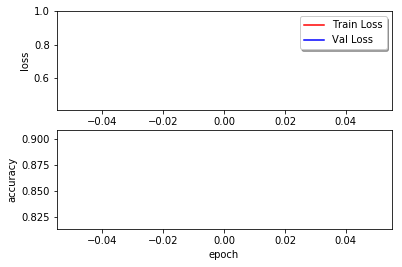

EPOCH: 2
TRAIN LOSS: 0.37016337801555516
VAL LOSS: 0.3267273849175446
VAL ACCURACY: 89.6 %
TIME: 2038.0 s


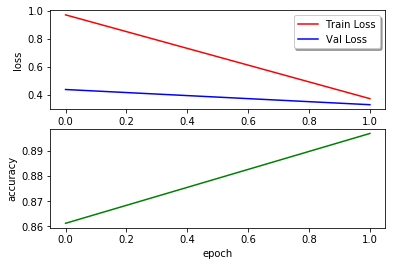

EPOCH: 3
TRAIN LOSS: 0.2877696459258846
VAL LOSS: 0.2719077793189156
VAL ACCURACY: 91.4 %
TIME: 234.4 s


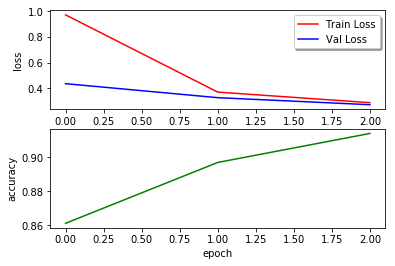

EPOCH: 4
TRAIN LOSS: 0.2328496871398088
VAL LOSS: 0.229206285166197
VAL ACCURACY: 93.0 %
TIME: 223.9 s


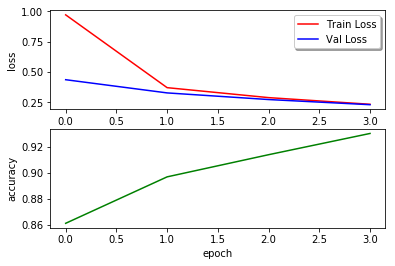

EPOCH: 5
TRAIN LOSS: 0.1958630972560268
VAL LOSS: 0.19589799318836995
VAL ACCURACY: 93.7 %
TIME: 228.4 s


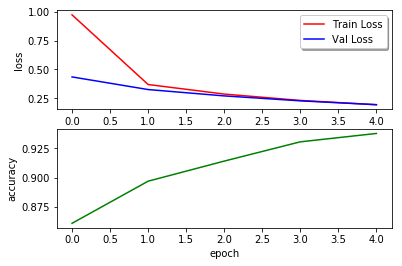

EPOCH: 6
TRAIN LOSS: 0.1722915211645941
VAL LOSS: 0.17712481967058247
VAL ACCURACY: 94.6 %
TIME: 240.7 s


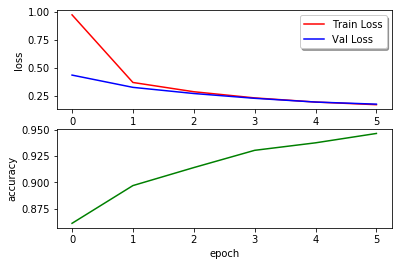

EPOCH: 7
TRAIN LOSS: 0.14879605204143062
VAL LOSS: 0.16249414850967087
VAL ACCURACY: 94.9 %
TIME: 275.7 s


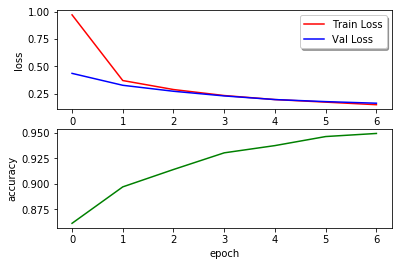

EPOCH: 8
TRAIN LOSS: 0.1361050162468213
VAL LOSS: 0.1493802342667445
VAL ACCURACY: 95.3 %
TIME: 229.5 s


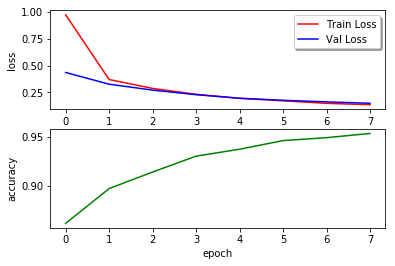

EPOCH: 9
TRAIN LOSS: 0.12239119663840074
VAL LOSS: 0.15124129122928995
VAL ACCURACY: 95.4 %
TIME: 235.1 s


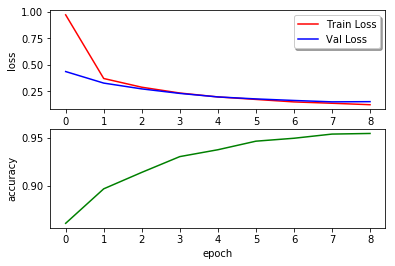

EPOCH: 10
TRAIN LOSS: 0.11076658757540334
VAL LOSS: 0.13541306156411434
VAL ACCURACY: 95.8 %
TIME: 223.2 s


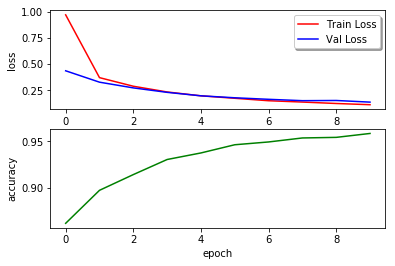

EPOCH: 11
TRAIN LOSS: 0.10148037428524875
VAL LOSS: 0.1325297060564421
VAL ACCURACY: 95.9 %
TIME: 223.5 s


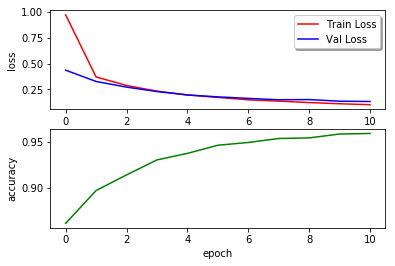

EPOCH: 12
TRAIN LOSS: 0.09248695549166258
VAL LOSS: 0.12558961795552717
VAL ACCURACY: 96.1 %
TIME: 224.6 s


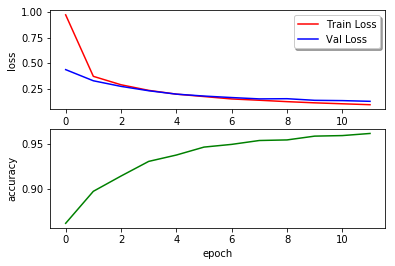

EPOCH: 13
TRAIN LOSS: 0.08527223278539388
VAL LOSS: 0.12773161567447724
VAL ACCURACY: 96.2 %
TIME: 224.0 s


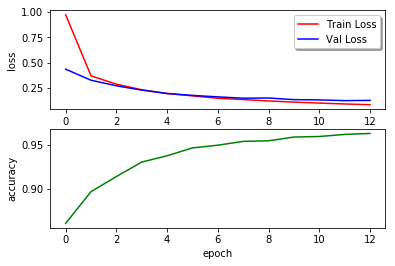

EPOCH: 14
TRAIN LOSS: 0.07948365680277278
VAL LOSS: 0.11444291330155641
VAL ACCURACY: 96.5 %
TIME: 224.4 s


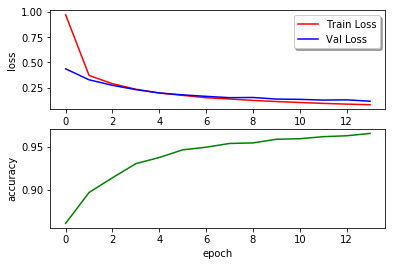

EPOCH: 15
TRAIN LOSS: 0.07446769864483983
VAL LOSS: 0.1039506970523699
VAL ACCURACY: 96.9 %
TIME: 223.8 s


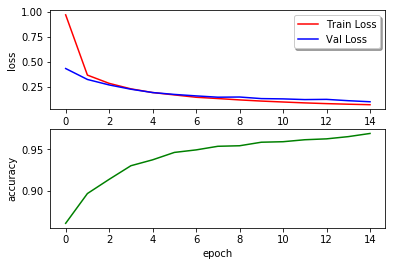

EPOCH: 16
TRAIN LOSS: 0.06724102852242764
VAL LOSS: 0.10915290409672163
VAL ACCURACY: 96.8 %
TIME: 223.6 s


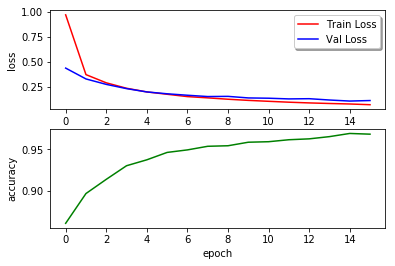

EPOCH: 17
TRAIN LOSS: 0.06501782905143244
VAL LOSS: 0.11155223387594083
VAL ACCURACY: 96.7 %
TIME: 223.8 s


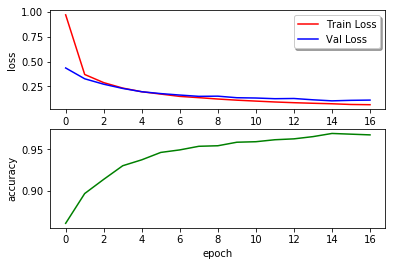

EPOCH: 18
TRAIN LOSS: 0.058062969435608555
VAL LOSS: 0.10844343863814332
VAL ACCURACY: 96.9 %
TIME: 237.0 s


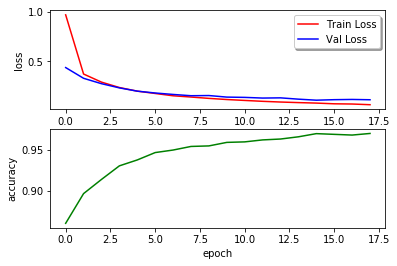

EPOCH: 19
TRAIN LOSS: 0.060183490053896845
VAL LOSS: 0.11606398640065778
VAL ACCURACY: 96.6 %
TIME: 323.1 s


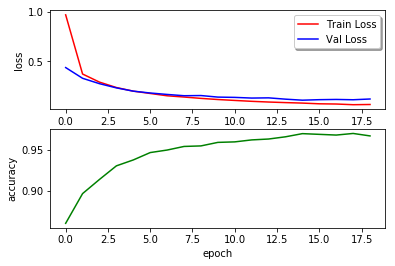

EPOCH: 20
TRAIN LOSS: 0.053786665405265256
VAL LOSS: 0.11041532329597278
VAL ACCURACY: 96.8 %
TIME: 318.1 s


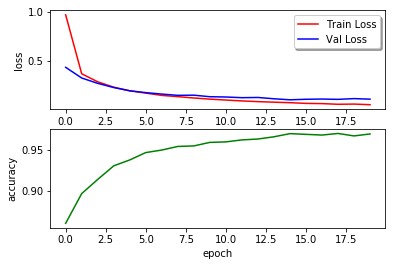

EPOCH: 21
TRAIN LOSS: 0.04953582911584783
VAL LOSS: 0.11149751274550429
VAL ACCURACY: 97.0 %
TIME: 321.5 s


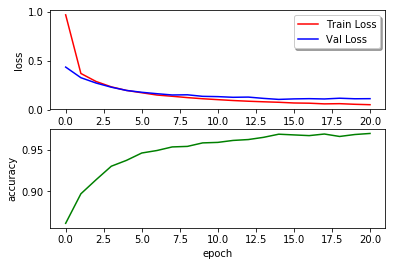

EPOCH: 22
TRAIN LOSS: 0.04830161859496716
VAL LOSS: 0.11654546053574164
VAL ACCURACY: 96.8 %
TIME: 334.2 s


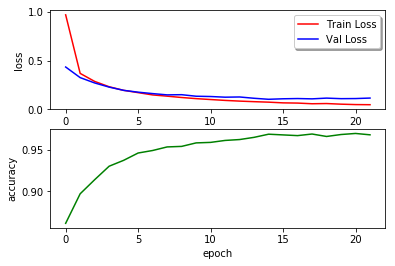

EPOCH: 23
TRAIN LOSS: 0.044729584624507844
VAL LOSS: 0.11119820633555906
VAL ACCURACY: 97.0 %
TIME: 316.9 s


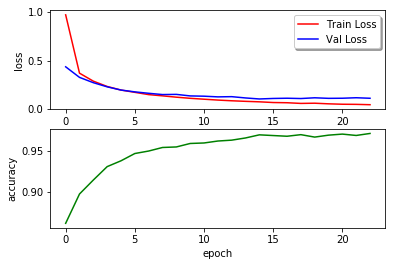

EPOCH: 24
TRAIN LOSS: 0.040814775770905344
VAL LOSS: 0.1273384751448417
VAL ACCURACY: 96.6 %
TIME: 329.6 s


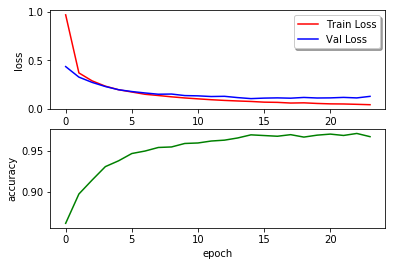

EPOCH: 25
TRAIN LOSS: 0.04090622425954716
VAL LOSS: 0.10720594972786447
VAL ACCURACY: 97.2 %
TIME: 319.0 s


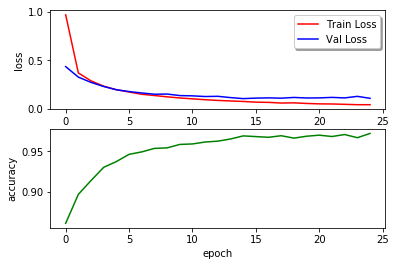

EPOCH: 26
TRAIN LOSS: 0.037459244475166124
VAL LOSS: 0.11391827858220892
VAL ACCURACY: 97.1 %
TIME: 319.5 s


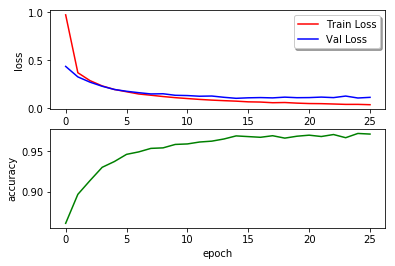

EPOCH: 27
TRAIN LOSS: 0.03499231733127914
VAL LOSS: 0.11304439572062908
VAL ACCURACY: 97.1 %
TIME: 317.2 s


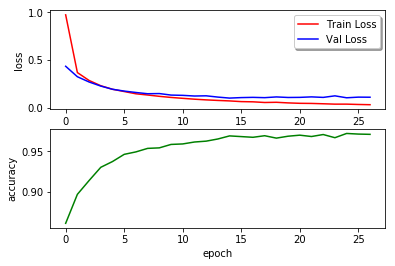

EPOCH: 28
TRAIN LOSS: 0.03403753784810145
VAL LOSS: 0.12509439036349063
VAL ACCURACY: 97.0 %
TIME: 314.6 s


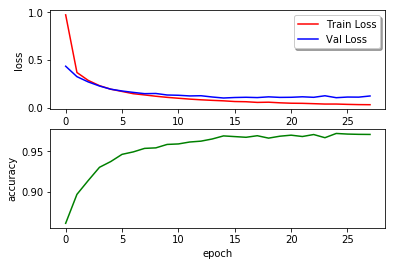

EPOCH: 29
TRAIN LOSS: 0.03223483340920451
VAL LOSS: 0.11583080032613309
VAL ACCURACY: 97.2 %
TIME: 312.8 s


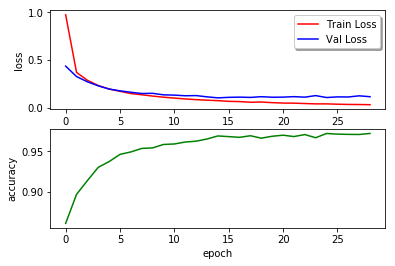

EPOCH: 30
TRAIN LOSS: 0.03236612408407774
VAL LOSS: 0.12347722857442672
VAL ACCURACY: 97.0 %
TIME: 316.3 s


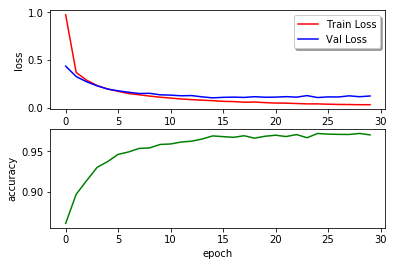

EPOCH: 31
TRAIN LOSS: 0.02923858409629121
VAL LOSS: 0.1130076475353734
VAL ACCURACY: 97.5 %
TIME: 332.9 s


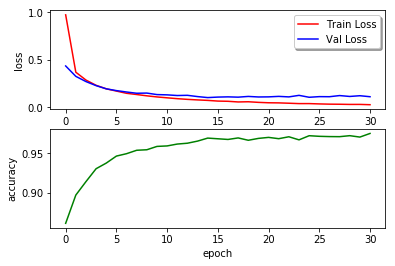

EPOCH: 32
TRAIN LOSS: 0.027231515521139307
VAL LOSS: 0.1045018499776818
VAL ACCURACY: 97.5 %
TIME: 359.0 s


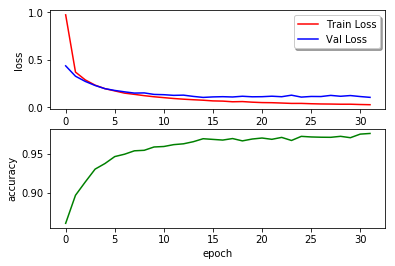

EPOCH: 33
TRAIN LOSS: 0.02459952536568054
VAL LOSS: 0.12464596924070112
VAL ACCURACY: 96.9 %
TIME: 350.4 s


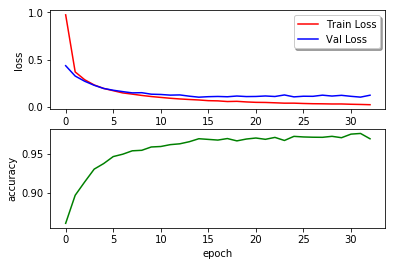

EPOCH: 34
TRAIN LOSS: 0.02663928235362794
VAL LOSS: 0.11802508831374799
VAL ACCURACY: 97.1 %
TIME: 356.8 s


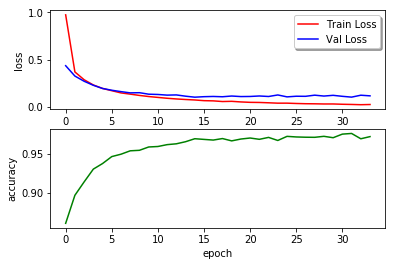

EPOCH: 35
TRAIN LOSS: 0.02641371990720791
VAL LOSS: 0.11294201108046817
VAL ACCURACY: 97.5 %
TIME: 339.2 s


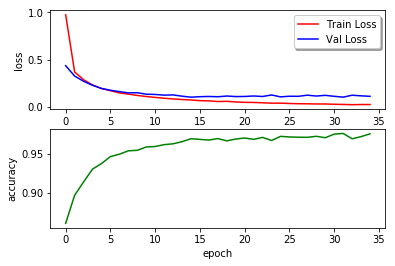

EPOCH: 36
TRAIN LOSS: 0.02276633398975333
VAL LOSS: 0.12383166406253333
VAL ACCURACY: 97.3 %
TIME: 376.9 s


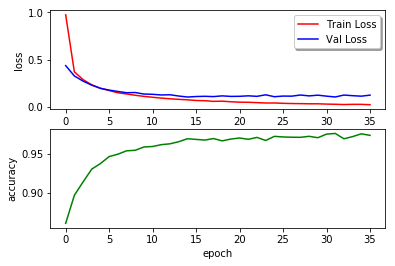

EPOCH: 37
TRAIN LOSS: 0.02316141877261302
VAL LOSS: 0.10710032055853042
VAL ACCURACY: 97.5 %
TIME: 374.3 s


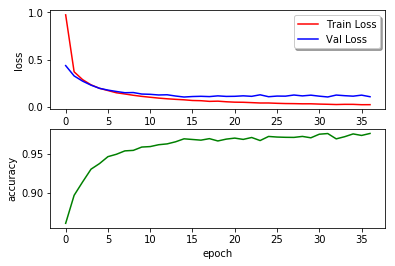

EPOCH: 38
TRAIN LOSS: 0.022090613784997017
VAL LOSS: 0.11905783374486544
VAL ACCURACY: 97.6 %
TIME: 490.4 s


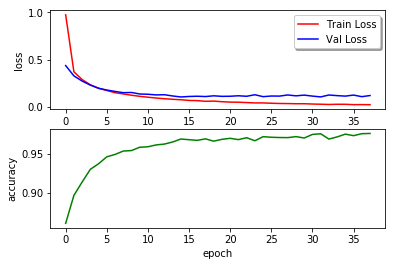

EPOCH: 39
TRAIN LOSS: 0.018741123213641728
VAL LOSS: 0.11936011921666198
VAL ACCURACY: 97.6 %
TIME: 564.6 s


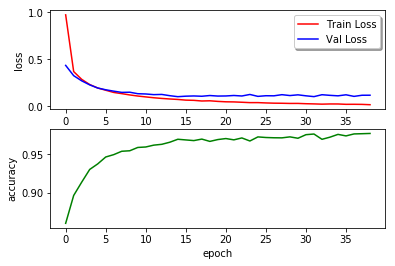

EPOCH: 40
TRAIN LOSS: 0.022644123724830652
VAL LOSS: 0.1246968617815736
VAL ACCURACY: 97.5 %
TIME: 533.0 s


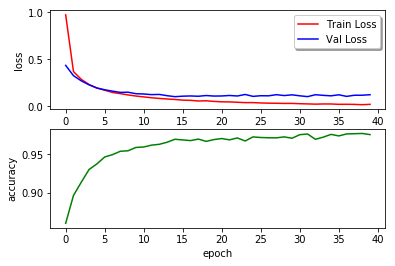

EPOCH: 41
TRAIN LOSS: 0.02039131330205098
VAL LOSS: 0.1171537490039114
VAL ACCURACY: 97.4 %
TIME: 532.5 s


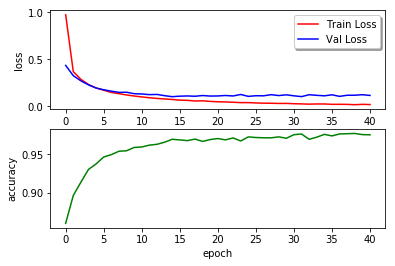

EPOCH: 42
TRAIN LOSS: 0.019373004208820956
VAL LOSS: 0.1257179048517884
VAL ACCURACY: 97.6 %
TIME: 521.3 s


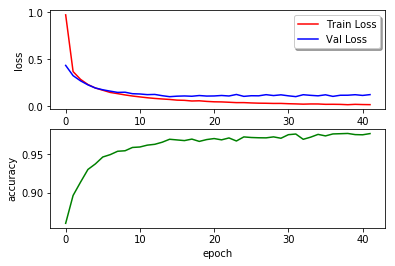

EPOCH: 43
TRAIN LOSS: 0.020588350941175143
VAL LOSS: 0.1244084393333497
VAL ACCURACY: 97.5 %
TIME: 503.4 s


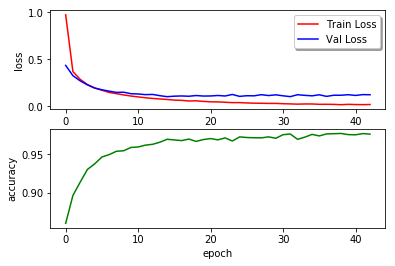

EPOCH: 44
TRAIN LOSS: 0.01582869786091599
VAL LOSS: 0.13174766613875455
VAL ACCURACY: 97.5 %
TIME: 453.4 s


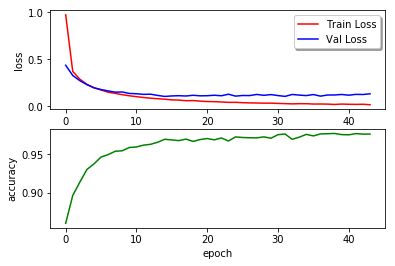

EPOCH: 45
TRAIN LOSS: 0.016149015802635235
VAL LOSS: 0.1202122861345844
VAL ACCURACY: 97.6 %
TIME: 555.8 s


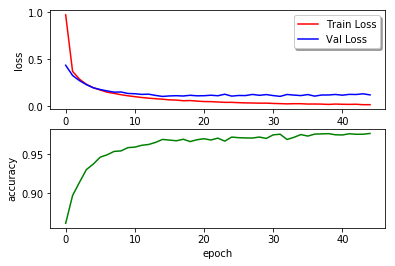

EPOCH: 46
TRAIN LOSS: 0.017632845703477076
VAL LOSS: 0.12563832311012704
VAL ACCURACY: 97.7 %
TIME: 421.0 s


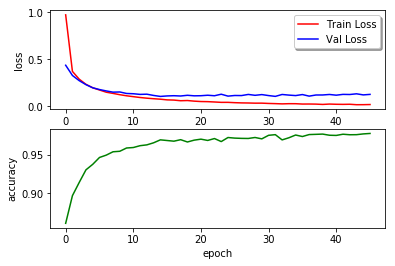

EPOCH: 47
TRAIN LOSS: 0.013844318661483047
VAL LOSS: 0.12836965103337594
VAL ACCURACY: 97.4 %
TIME: 426.7 s


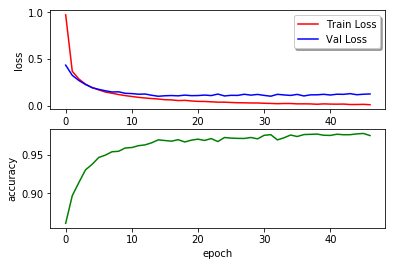

EPOCH: 48
TRAIN LOSS: 0.01483777783108385
VAL LOSS: 0.1183723163721603
VAL ACCURACY: 97.7 %
TIME: 418.5 s


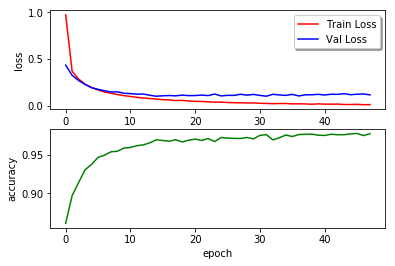

EPOCH: 49
TRAIN LOSS: 0.013948268827332248
VAL LOSS: 0.13460143609209638
VAL ACCURACY: 97.6 %
TIME: 420.0 s


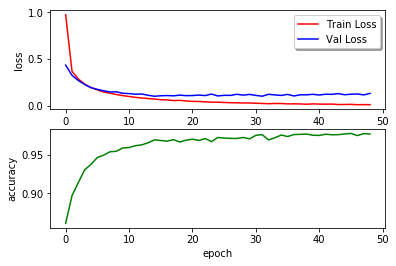

EPOCH: 50
TRAIN LOSS: 0.014610331605584085
VAL LOSS: 0.13451195706344843
VAL ACCURACY: 97.3 %
TIME: 422.6 s


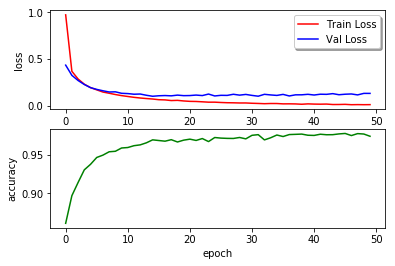

EPOCH: 51
TRAIN LOSS: 0.01461000655546466
VAL LOSS: 0.1338673132816634
VAL ACCURACY: 97.7 %
TIME: 417.7 s


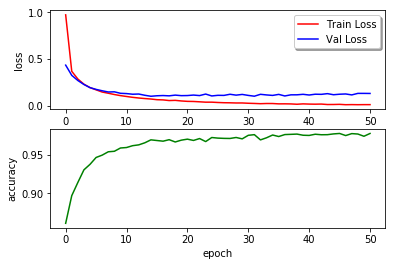

EPOCH: 52
TRAIN LOSS: 0.013022289776425751
VAL LOSS: 0.1267095831335727
VAL ACCURACY: 97.7 %
TIME: 413.0 s


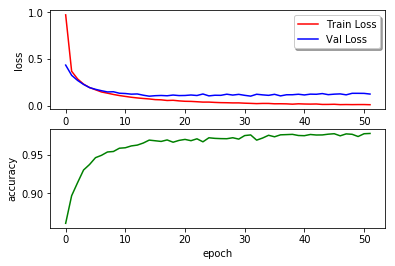

EPOCH: 53
TRAIN LOSS: 0.013155424976614946
VAL LOSS: 0.13416259127865623
VAL ACCURACY: 97.5 %
TIME: 419.8 s


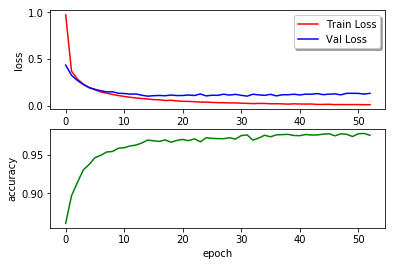

EPOCH: 54
TRAIN LOSS: 0.0160963451700992
VAL LOSS: 0.1424442563815534
VAL ACCURACY: 97.4 %
TIME: 418.6 s


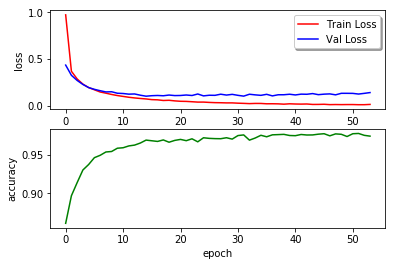

EPOCH: 55
TRAIN LOSS: 0.012548877452728644
VAL LOSS: 0.13236233672272327
VAL ACCURACY: 97.6 %
TIME: 413.2 s


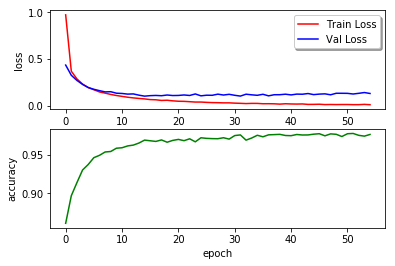

EPOCH: 56
TRAIN LOSS: 0.012105977664634225
VAL LOSS: 0.13270693140415504
VAL ACCURACY: 97.5 %
TIME: 414.3 s


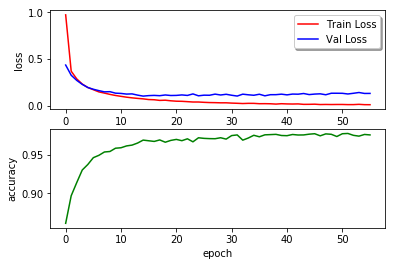

EPOCH: 57
TRAIN LOSS: 0.012240808118972801
VAL LOSS: 0.15166070854556113
VAL ACCURACY: 97.4 %
TIME: 411.6 s


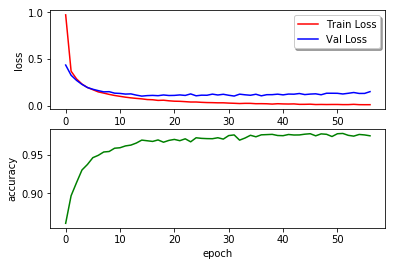

EPOCH: 58
TRAIN LOSS: 0.013096934054211381
VAL LOSS: 0.1465430863469353
VAL ACCURACY: 97.4 %
TIME: 412.6 s


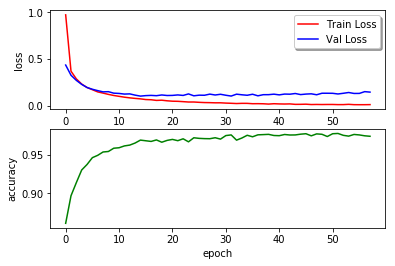

EPOCH: 59
TRAIN LOSS: 0.012761343050363324
VAL LOSS: 0.13818526024826738
VAL ACCURACY: 97.6 %
TIME: 412.4 s


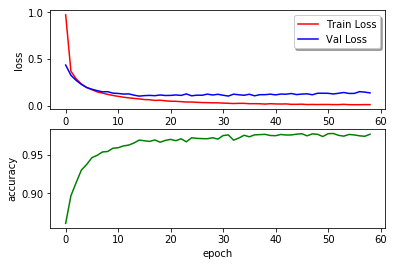

EPOCH: 60
TRAIN LOSS: 0.011912920388679596
VAL LOSS: 0.14674213490329724
VAL ACCURACY: 97.3 %
TIME: 417.0 s


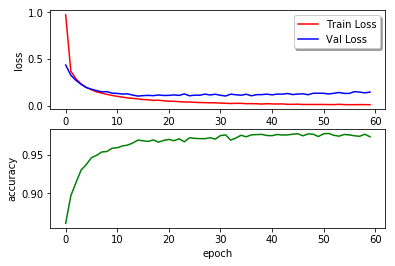

EPOCH: 61
TRAIN LOSS: 0.01185227768361615
VAL LOSS: 0.13393802693480059
VAL ACCURACY: 97.6 %
TIME: 417.1 s


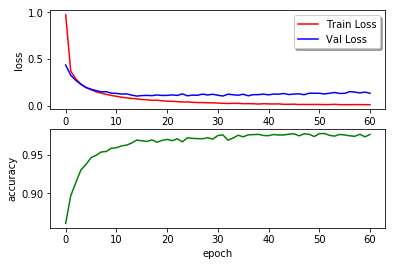

EPOCH: 62
TRAIN LOSS: 0.010260267439752177
VAL LOSS: 0.14921207263129585
VAL ACCURACY: 97.7 %
TIME: 420.5 s


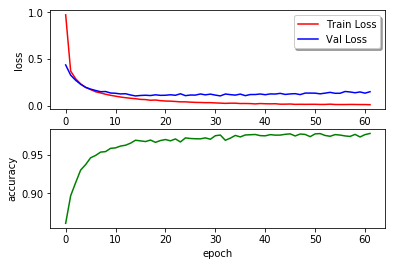

EPOCH: 63
TRAIN LOSS: 0.009818783963772856
VAL LOSS: 0.15122409815287333
VAL ACCURACY: 97.5 %
TIME: 414.4 s


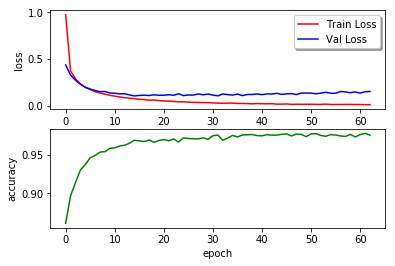

EPOCH: 64
TRAIN LOSS: 0.010887588250919357
VAL LOSS: 0.1399975819891584
VAL ACCURACY: 97.6 %
TIME: 415.5 s


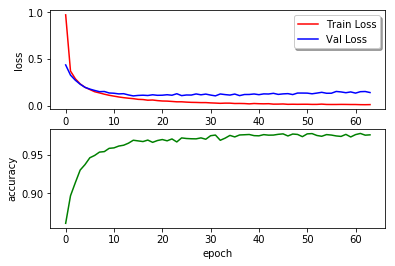

EPOCH: 65
TRAIN LOSS: 0.009915662718110228
VAL LOSS: 0.14574951729468186
VAL ACCURACY: 97.8 %
TIME: 417.1 s


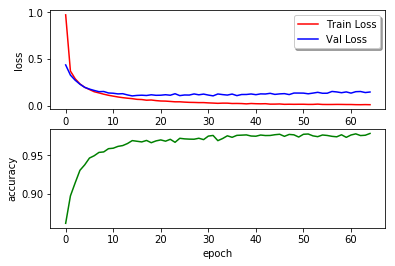

EPOCH: 66
TRAIN LOSS: 0.010554970721128678
VAL LOSS: 0.1475287054988328
VAL ACCURACY: 97.6 %
TIME: 418.2 s


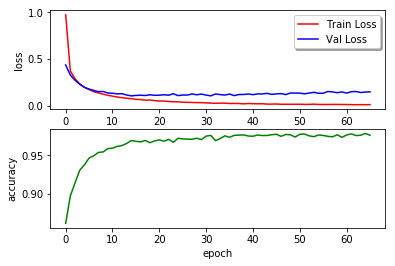

EPOCH: 67
TRAIN LOSS: 0.015023776053765052
VAL LOSS: 0.14799539215240298
VAL ACCURACY: 97.5 %
TIME: 416.2 s


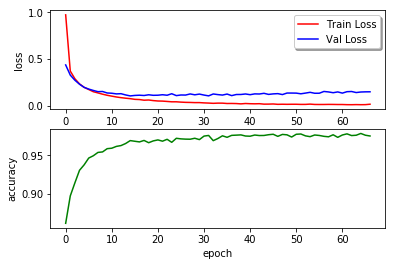

EPOCH: 68
TRAIN LOSS: 0.007610972682178079
VAL LOSS: 0.15188164827296502
VAL ACCURACY: 97.6 %
TIME: 417.7 s


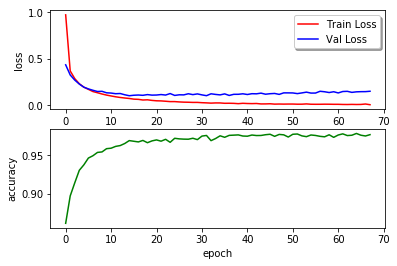

EPOCH: 69
TRAIN LOSS: 0.008152985503860039
VAL LOSS: 0.15660919268104076
VAL ACCURACY: 97.6 %
TIME: 416.4 s


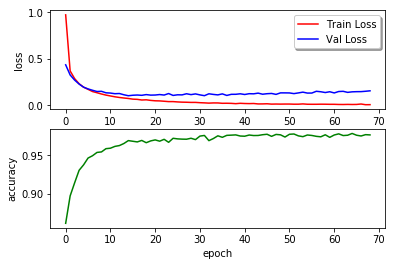

EPOCH: 70
TRAIN LOSS: 0.008216027803816528
VAL LOSS: 0.14907651296951077
VAL ACCURACY: 97.6 %
TIME: 413.8 s


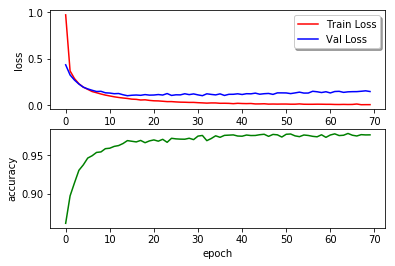

EPOCH: 71
TRAIN LOSS: 0.008098069556562539
VAL LOSS: 0.1531544532891248
VAL ACCURACY: 97.6 %
TIME: 417.1 s


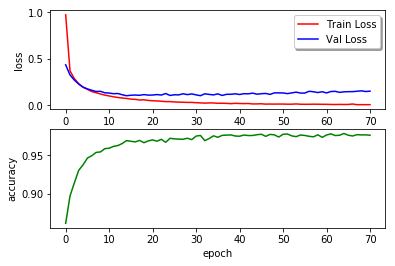

EPOCH: 72
TRAIN LOSS: 0.009932938176311594
VAL LOSS: 0.16907178468460887
VAL ACCURACY: 97.3 %
TIME: 415.3 s


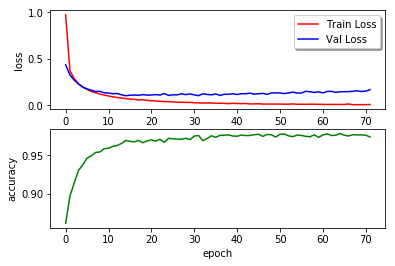

EPOCH: 73
TRAIN LOSS: 0.00934327333484624
VAL LOSS: 0.16125669156421069
VAL ACCURACY: 97.7 %
TIME: 413.3 s


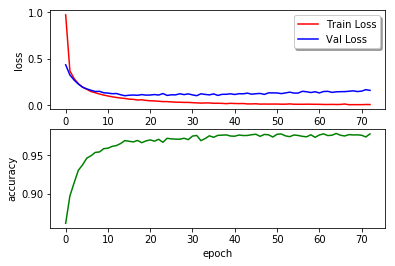

EPOCH: 74
TRAIN LOSS: 0.01032578569066284
VAL LOSS: 0.17294775687934913
VAL ACCURACY: 97.4 %
TIME: 415.4 s


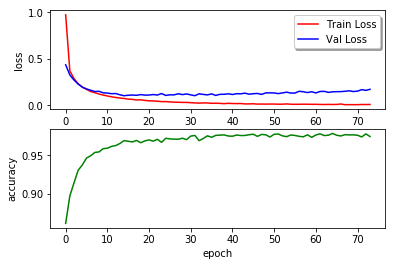

EPOCH: 75
TRAIN LOSS: 0.008095756174866266
VAL LOSS: 0.1517162504846479
VAL ACCURACY: 97.7 %
TIME: 415.2 s


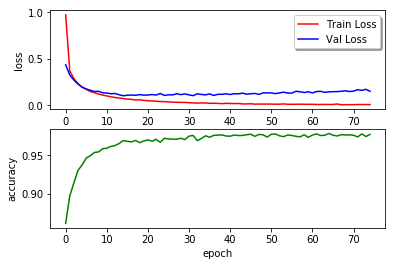

EPOCH: 76
TRAIN LOSS: 0.008010048255491993
VAL LOSS: 0.1585854474427602
VAL ACCURACY: 97.7 %
TIME: 411.7 s


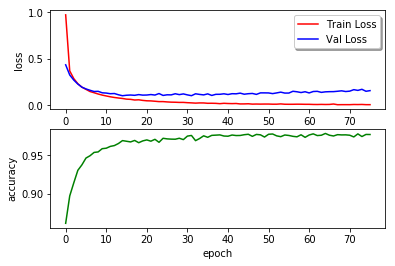

EPOCH: 77
TRAIN LOSS: 0.008087332002357275
VAL LOSS: 0.15454343881398241
VAL ACCURACY: 97.7 %
TIME: 416.1 s


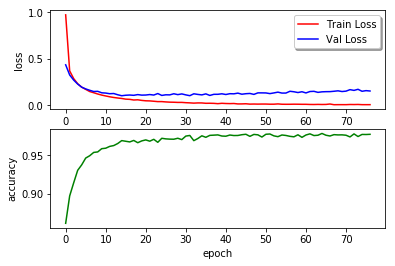

EPOCH: 78
TRAIN LOSS: 0.007320534973755104
VAL LOSS: 0.1573393154743612
VAL ACCURACY: 97.7 %
TIME: 416.2 s


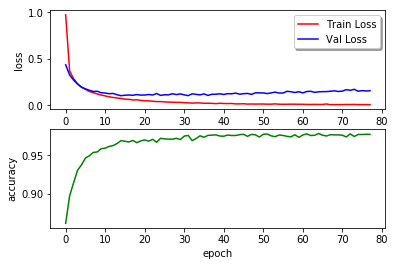

EPOCH: 79
TRAIN LOSS: 0.00884241536465642
VAL LOSS: 0.16734405525166515
VAL ACCURACY: 97.4 %
TIME: 416.6 s


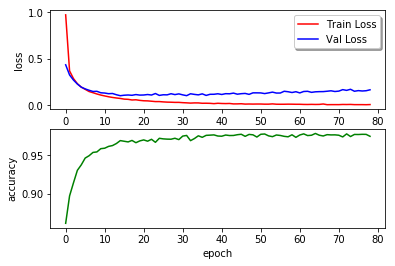

EPOCH: 80
TRAIN LOSS: 0.009889279235191582
VAL LOSS: 0.16235301194073143
VAL ACCURACY: 97.7 %
TIME: 420.6 s


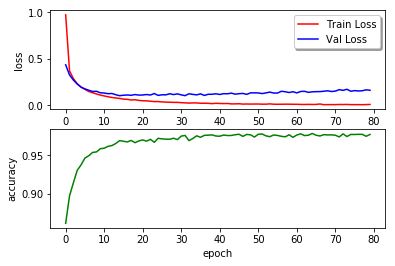

EPOCH: 81
TRAIN LOSS: 0.009049684900487779
VAL LOSS: 0.1541129052167336
VAL ACCURACY: 97.7 %
TIME: 416.6 s


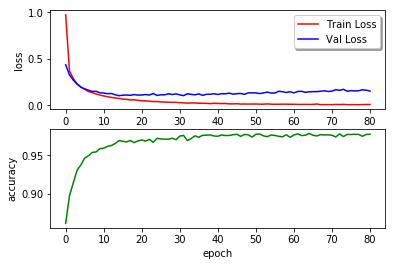

EPOCH: 82
TRAIN LOSS: 0.007209933322284867
VAL LOSS: 0.17189619564929476
VAL ACCURACY: 97.7 %
TIME: 412.3 s


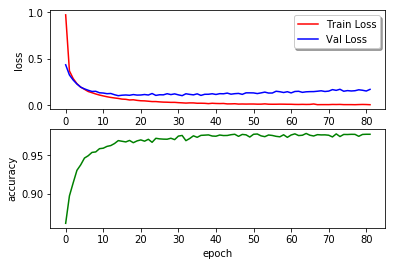

EPOCH: 83
TRAIN LOSS: 0.007240131773269711
VAL LOSS: 0.1638854337260167
VAL ACCURACY: 97.7 %
TIME: 413.3 s


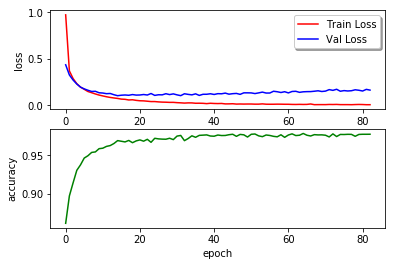

EPOCH: 84
TRAIN LOSS: 0.008213561478665145
VAL LOSS: 0.16134070929968314
VAL ACCURACY: 97.7 %
TIME: 413.7 s


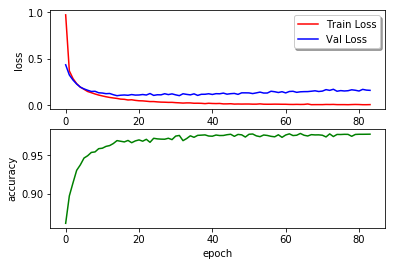

EPOCH: 85
TRAIN LOSS: 0.007633992700488135
VAL LOSS: 0.16913445522426448
VAL ACCURACY: 97.5 %
TIME: 412.6 s


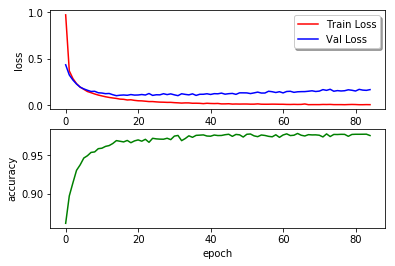

EPOCH: 86
TRAIN LOSS: 0.007788614403652904
VAL LOSS: 0.16113861141277525
VAL ACCURACY: 97.7 %
TIME: 417.7 s


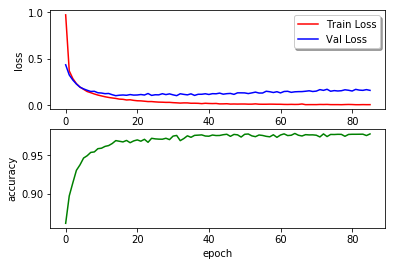

EPOCH: 87
TRAIN LOSS: 0.0076990316489482
VAL LOSS: 0.1555346674142167
VAL ACCURACY: 97.6 %
TIME: 410.4 s


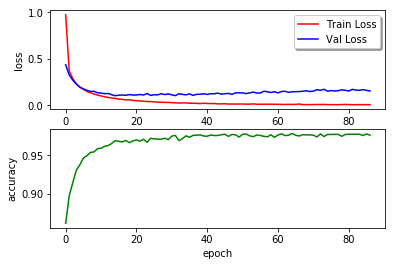

EPOCH: 88
TRAIN LOSS: 0.007359192460611107
VAL LOSS: 0.16006909936831729
VAL ACCURACY: 97.7 %
TIME: 420.1 s


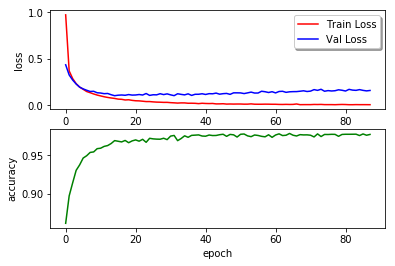

EPOCH: 89
TRAIN LOSS: 0.007548794080036233
VAL LOSS: 0.16782367311374508
VAL ACCURACY: 97.8 %
TIME: 412.2 s


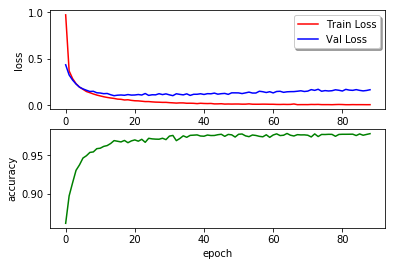

EPOCH: 90
TRAIN LOSS: 0.006583656304698519
VAL LOSS: 0.173759070311443
VAL ACCURACY: 97.6 %
TIME: 420.0 s


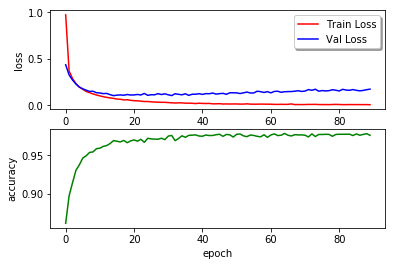

EPOCH: 91
TRAIN LOSS: 0.006824967377214081
VAL LOSS: 0.1634175212672554
VAL ACCURACY: 97.7 %
TIME: 413.1 s


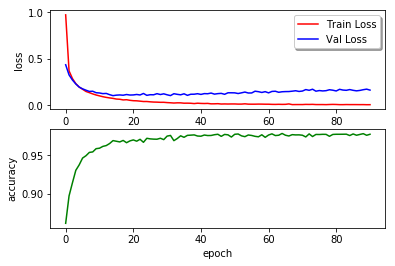

EPOCH: 92
TRAIN LOSS: 0.008054813810202842
VAL LOSS: 0.18082277879376324
VAL ACCURACY: 97.0 %
TIME: 414.8 s


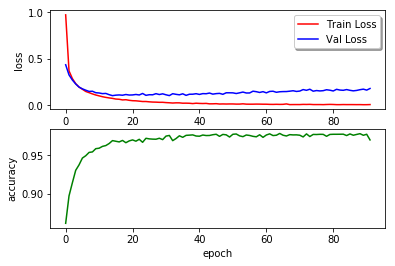

EPOCH: 93
TRAIN LOSS: 0.006458952085798757
VAL LOSS: 0.16432875129211208
VAL ACCURACY: 97.7 %
TIME: 413.9 s


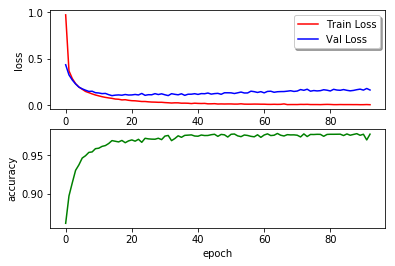

EPOCH: 94
TRAIN LOSS: 0.0056656124107177614
VAL LOSS: 0.1700549793715764
VAL ACCURACY: 97.8 %
TIME: 416.5 s


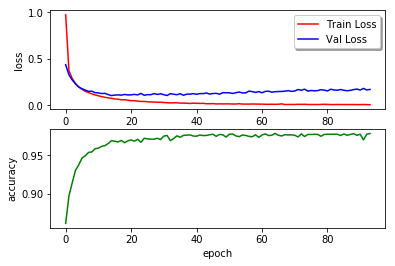

EPOCH: 95
TRAIN LOSS: 0.006002878502354345
VAL LOSS: 0.16959774259914795
VAL ACCURACY: 97.6 %
TIME: 418.9 s


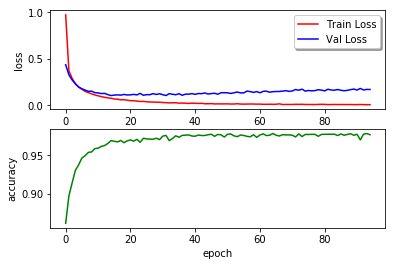

EPOCH: 96
TRAIN LOSS: 0.007542370977689832
VAL LOSS: 0.17996546175024003
VAL ACCURACY: 97.7 %
TIME: 414.1 s


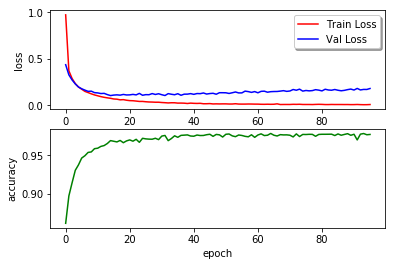

EPOCH: 97
TRAIN LOSS: 0.008930844628899249
VAL LOSS: 0.16341879814357702
VAL ACCURACY: 97.6 %
TIME: 413.9 s


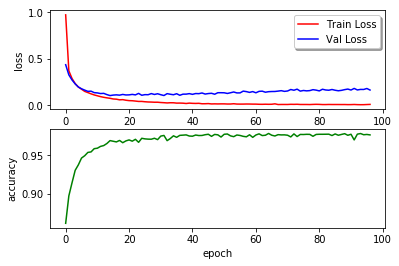

EPOCH: 98
TRAIN LOSS: 0.00528990158425962
VAL LOSS: 0.17515848739097395
VAL ACCURACY: 97.7 %
TIME: 415.9 s


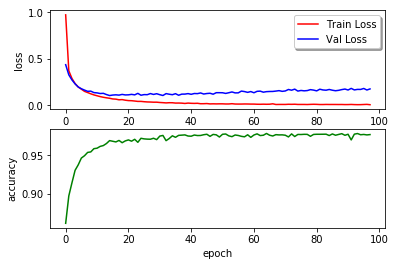

EPOCH: 99
TRAIN LOSS: 0.008781333071512678
VAL LOSS: 0.16658356464441862
VAL ACCURACY: 97.7 %
TIME: 411.1 s


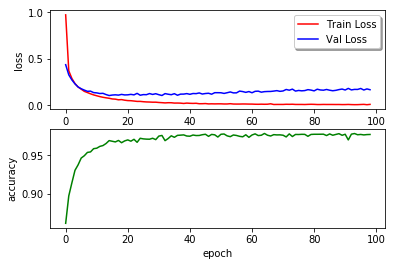

EPOCH: 100
TRAIN LOSS: 0.006462827854698404
VAL LOSS: 0.16148623859403377
VAL ACCURACY: 97.4 %
TIME: 415.3 s


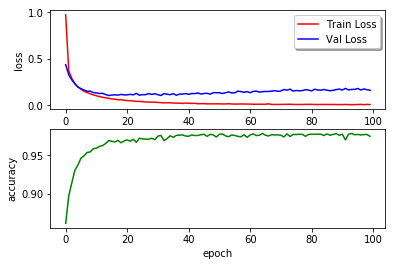

EPOCH: 101
TRAIN LOSS: 0.005754656341498647
VAL LOSS: 0.17081108817695068
VAL ACCURACY: 97.6 %
TIME: 412.2 s


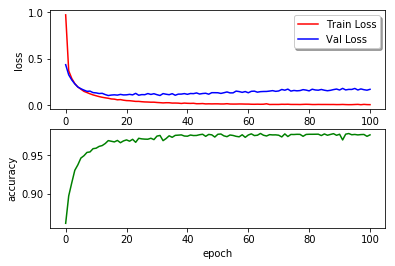

EPOCH: 102
TRAIN LOSS: 0.0070771172112168435
VAL LOSS: 0.18034301600303884
VAL ACCURACY: 97.7 %
TIME: 414.2 s


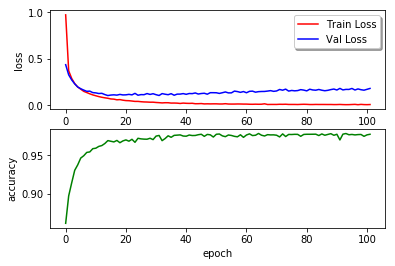

EPOCH: 103
TRAIN LOSS: 0.007749205261705979
VAL LOSS: 0.16765644735858823
VAL ACCURACY: 97.7 %
TIME: 416.2 s


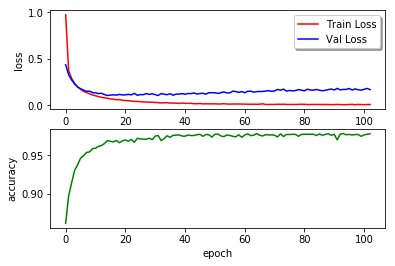

EPOCH: 104
TRAIN LOSS: 0.005648145650777982
VAL LOSS: 0.1747922678239423
VAL ACCURACY: 97.6 %
TIME: 416.0 s


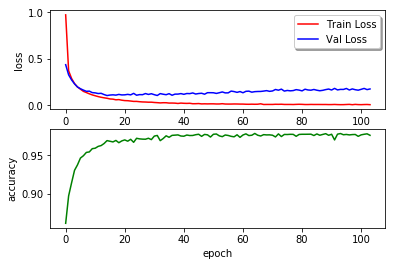

EPOCH: 105
TRAIN LOSS: 0.004952190429596047
VAL LOSS: 0.15870745810387846
VAL ACCURACY: 97.7 %
TIME: 412.8 s


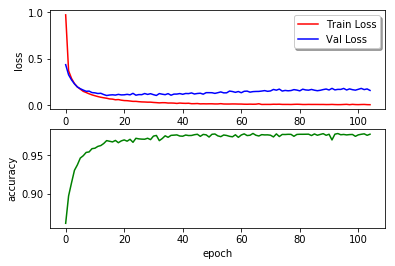

EPOCH: 106
TRAIN LOSS: 0.006105997160858922
VAL LOSS: 0.17292906269509586
VAL ACCURACY: 97.7 %
TIME: 411.3 s


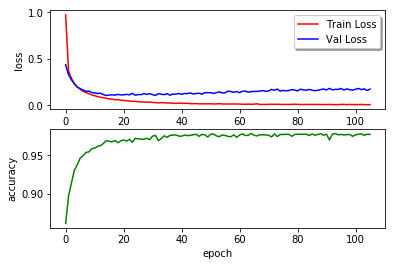

EPOCH: 107
TRAIN LOSS: 0.0077228381463788735
VAL LOSS: 0.18460975912265865
VAL ACCURACY: 97.7 %
TIME: 414.4 s


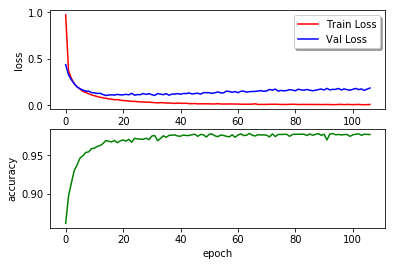

EPOCH: 108
TRAIN LOSS: 0.0047700336551045885
VAL LOSS: 0.1773737383259767
VAL ACCURACY: 97.7 %
TIME: 407.8 s


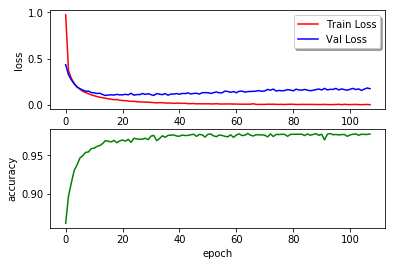

EPOCH: 109
TRAIN LOSS: 0.0035802609425596797
VAL LOSS: 0.1757800859537713
VAL ACCURACY: 97.8 %
TIME: 415.0 s


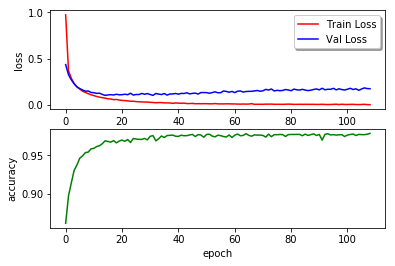

EPOCH: 110
TRAIN LOSS: 0.004370146303445692
VAL LOSS: 0.2091714802571287
VAL ACCURACY: 97.7 %
TIME: 419.0 s


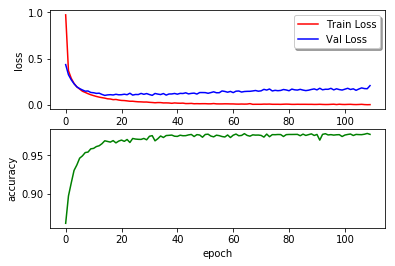

EPOCH: 111
TRAIN LOSS: 0.008686222842426546
VAL LOSS: 0.17241317646086232
VAL ACCURACY: 97.4 %
TIME: 417.2 s


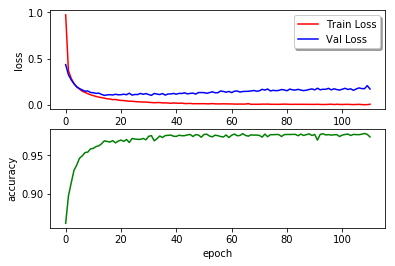

EPOCH: 112
TRAIN LOSS: 0.008791403438819921
VAL LOSS: 0.1619499454602821
VAL ACCURACY: 97.6 %
TIME: 413.5 s


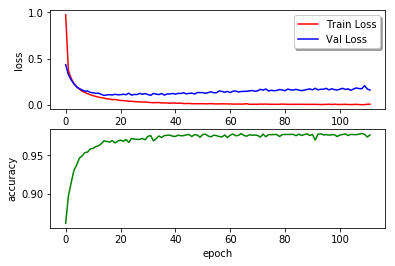

EPOCH: 113
TRAIN LOSS: 0.004945507453538835
VAL LOSS: 0.18156998511237255
VAL ACCURACY: 97.7 %
TIME: 415.2 s


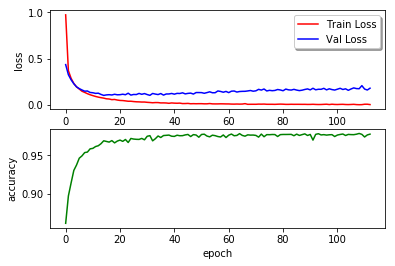

EPOCH: 114
TRAIN LOSS: 0.004963523402440825
VAL LOSS: 0.19057190380908523
VAL ACCURACY: 97.5 %
TIME: 415.4 s


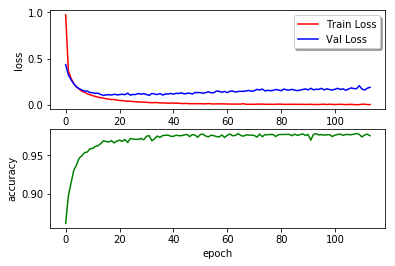

EPOCH: 115
TRAIN LOSS: 0.004434387310871543
VAL LOSS: 0.18186633419920806
VAL ACCURACY: 97.5 %
TIME: 409.2 s


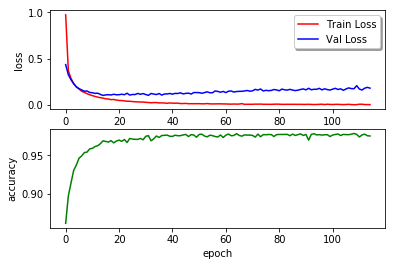

EPOCH: 116
TRAIN LOSS: 0.006225548358094264
VAL LOSS: 0.19698482245427193
VAL ACCURACY: 97.6 %
TIME: 413.1 s


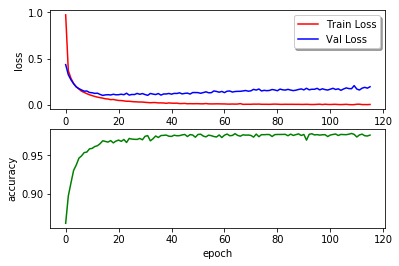

EPOCH: 117
TRAIN LOSS: 0.006711952694477602
VAL LOSS: 0.1888114881319591
VAL ACCURACY: 97.6 %
TIME: 322.9 s


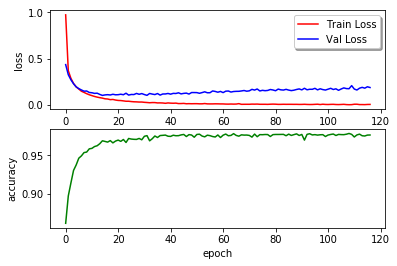

EPOCH: 118
TRAIN LOSS: 0.005848750958066466
VAL LOSS: 0.1681628276898266
VAL ACCURACY: 97.5 %
TIME: 302.9 s


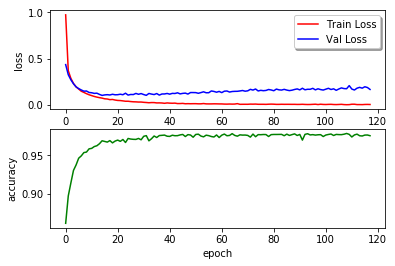

EPOCH: 119
TRAIN LOSS: 0.0055368700428437495
VAL LOSS: 0.18734379834779077
VAL ACCURACY: 97.7 %
TIME: 311.6 s


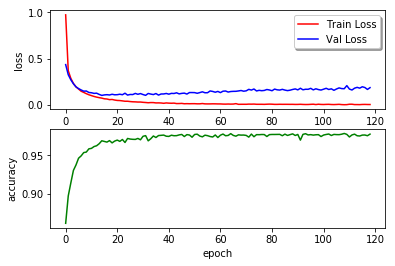

EPOCH: 120
TRAIN LOSS: 0.005968229270013074
VAL LOSS: 0.18450246487525016
VAL ACCURACY: 97.8 %
TIME: 310.4 s


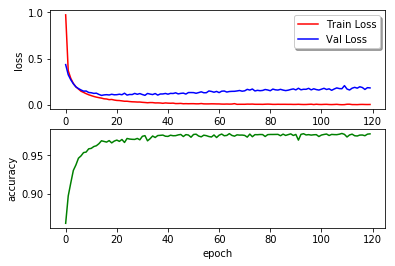

EPOCH: 121
TRAIN LOSS: 0.004183779235297396
VAL LOSS: 0.17588155011705764
VAL ACCURACY: 97.7 %
TIME: 308.0 s


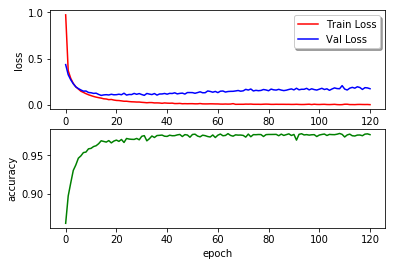

EPOCH: 122
TRAIN LOSS: 0.0059736322269683855
VAL LOSS: 0.16474793580562988
VAL ACCURACY: 97.8 %
TIME: 311.7 s


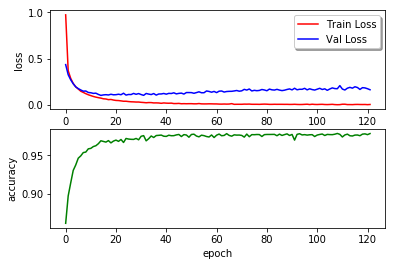

EPOCH: 123
TRAIN LOSS: 0.0051829283066852205
VAL LOSS: 0.18204213837904992
VAL ACCURACY: 97.7 %
TIME: 308.9 s


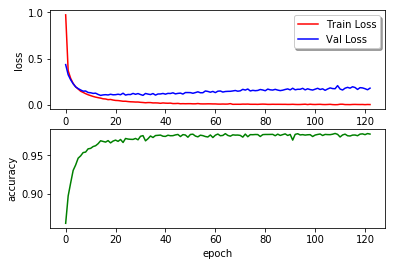

EPOCH: 124
TRAIN LOSS: 0.006159683096553675
VAL LOSS: 0.1779828233373578
VAL ACCURACY: 97.7 %
TIME: 310.4 s


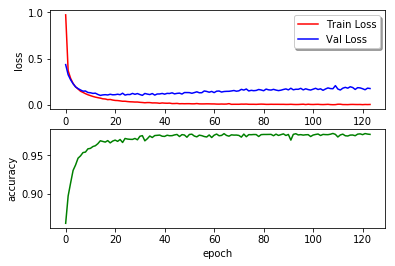

EPOCH: 125
TRAIN LOSS: 0.005017923617769192
VAL LOSS: 0.17781553154574942
VAL ACCURACY: 97.6 %
TIME: 309.0 s


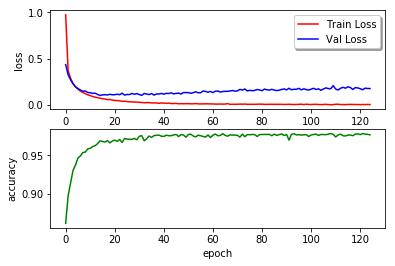

EPOCH: 126
TRAIN LOSS: 0.005164310556417818
VAL LOSS: 0.19553794279603065
VAL ACCURACY: 97.7 %
TIME: 306.2 s


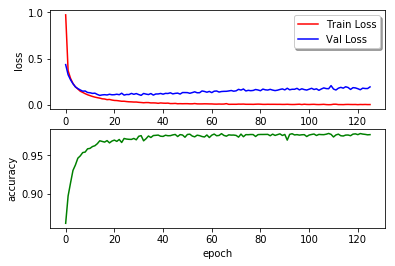

EPOCH: 127
TRAIN LOSS: 0.004330278846472348
VAL LOSS: 0.18805350391606845
VAL ACCURACY: 97.7 %
TIME: 310.2 s


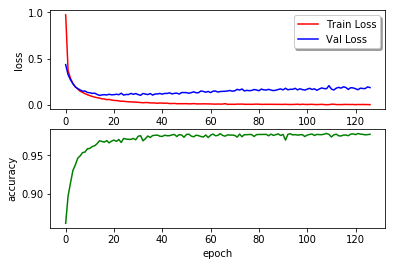

EPOCH: 128
TRAIN LOSS: 0.0058086263194266335
VAL LOSS: 0.17855664223775985
VAL ACCURACY: 97.7 %
TIME: 308.3 s


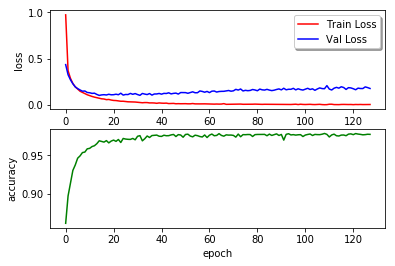

EPOCH: 129
TRAIN LOSS: 0.0037961024137993476
VAL LOSS: 0.19035676137371427
VAL ACCURACY: 97.8 %
TIME: 310.7 s


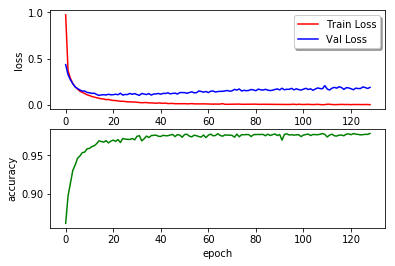

EPOCH: 130
TRAIN LOSS: 0.004476019552707763
VAL LOSS: 0.18094753017452556
VAL ACCURACY: 97.7 %
TIME: 305.2 s


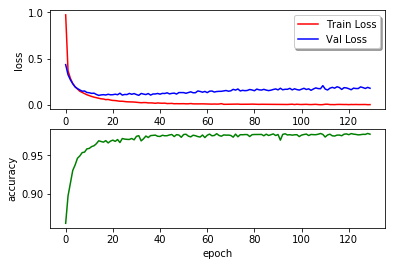

EPOCH: 131
TRAIN LOSS: 0.005265061400669528
VAL LOSS: 0.21190991151616986
VAL ACCURACY: 97.5 %
TIME: 308.0 s


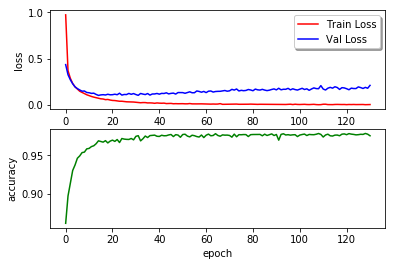

EPOCH: 132
TRAIN LOSS: 0.004507371303024693
VAL LOSS: 0.19812607919097694
VAL ACCURACY: 97.8 %
TIME: 305.5 s


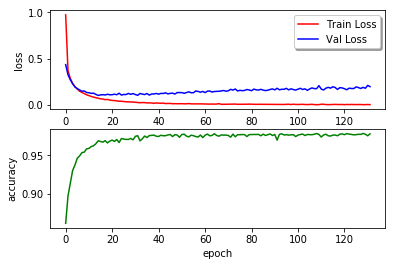

EPOCH: 133
TRAIN LOSS: 0.004559640576359982
VAL LOSS: 0.17091071442073158
VAL ACCURACY: 97.7 %
TIME: 308.4 s


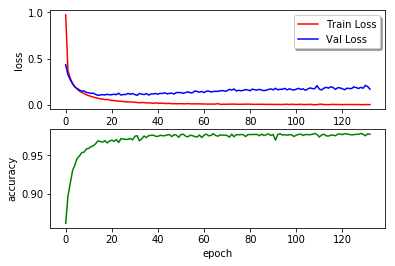

EPOCH: 134
TRAIN LOSS: 0.0052551441618264505
VAL LOSS: 0.18086124726893146
VAL ACCURACY: 97.7 %
TIME: 308.5 s


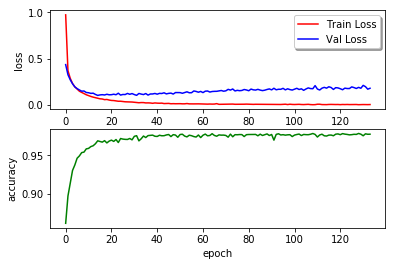

EPOCH: 135
TRAIN LOSS: 0.006104460709152124
VAL LOSS: 0.1838739442754827
VAL ACCURACY: 97.8 %
TIME: 307.4 s


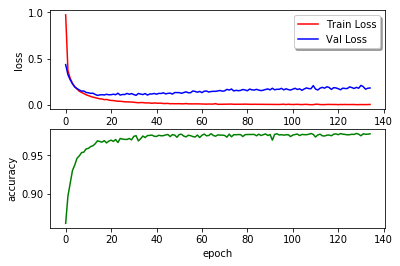

EPOCH: 136
TRAIN LOSS: 0.0055753207992632
VAL LOSS: 0.1918700245828885
VAL ACCURACY: 97.8 %
TIME: 308.8 s


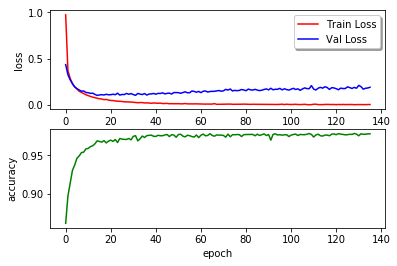

EPOCH: 137
TRAIN LOSS: 0.00479935541134471
VAL LOSS: 0.182985914837716
VAL ACCURACY: 97.8 %
TIME: 305.0 s


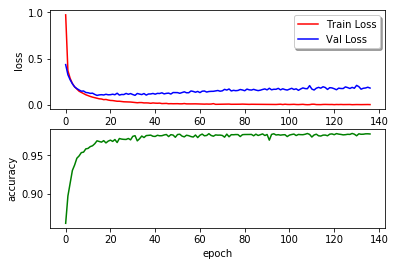

EPOCH: 138
TRAIN LOSS: 0.00446853129352686
VAL LOSS: 0.17946591444828963
VAL ACCURACY: 97.6 %
TIME: 306.2 s


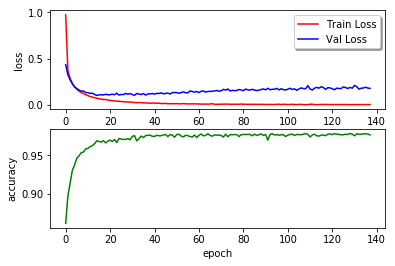

EPOCH: 139
TRAIN LOSS: 0.0030854800578693988
VAL LOSS: 0.19443161622913407
VAL ACCURACY: 97.7 %
TIME: 304.0 s


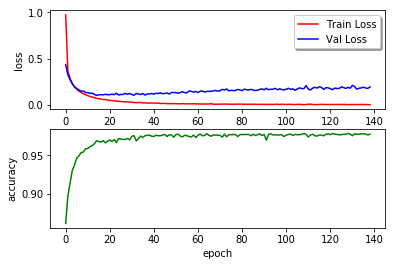

EPOCH: 140
TRAIN LOSS: 0.005226312837524503
VAL LOSS: 0.1859770871260862
VAL ACCURACY: 97.9 %
TIME: 303.6 s


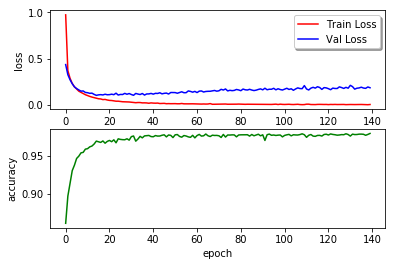

EPOCH: 141
TRAIN LOSS: 0.004154178186081448
VAL LOSS: 0.1975163746654046
VAL ACCURACY: 97.7 %
TIME: 305.9 s


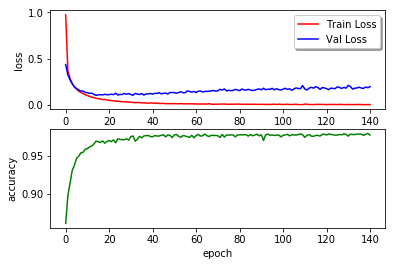

EPOCH: 142
TRAIN LOSS: 0.004475487297835212
VAL LOSS: 0.18749068908916847
VAL ACCURACY: 97.7 %
TIME: 307.5 s


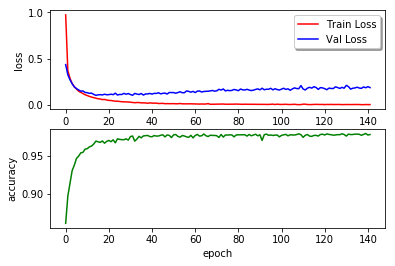

EPOCH: 143
TRAIN LOSS: 0.004781233401935416
VAL LOSS: 0.20690319019163794
VAL ACCURACY: 97.6 %
TIME: 308.5 s


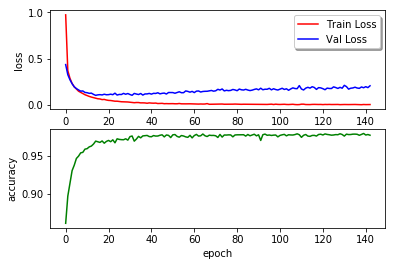

EPOCH: 144
TRAIN LOSS: 0.005265409505455256
VAL LOSS: 0.1855255075400161
VAL ACCURACY: 97.8 %
TIME: 304.9 s


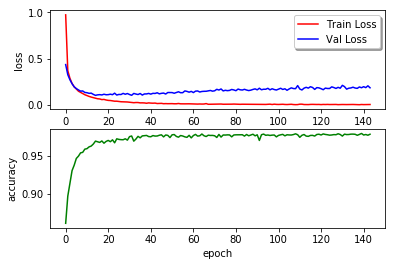

EPOCH: 145
TRAIN LOSS: 0.0038670141115477626
VAL LOSS: 0.17758612953550484
VAL ACCURACY: 97.8 %
TIME: 309.8 s


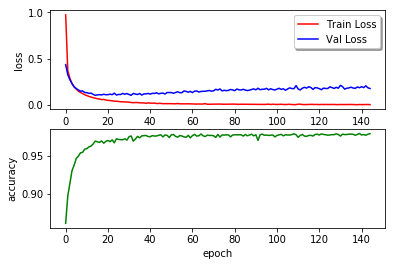

EPOCH: 146
TRAIN LOSS: 0.004046871187416696
VAL LOSS: 0.18608537829228936
VAL ACCURACY: 97.7 %
TIME: 309.0 s


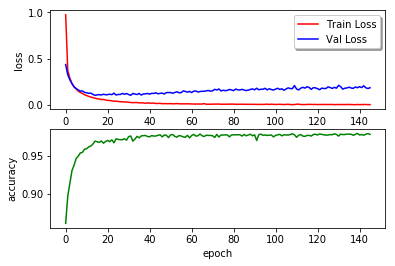

EPOCH: 147
TRAIN LOSS: 0.004863295720793355
VAL LOSS: 0.18401789694095336
VAL ACCURACY: 97.8 %
TIME: 308.1 s


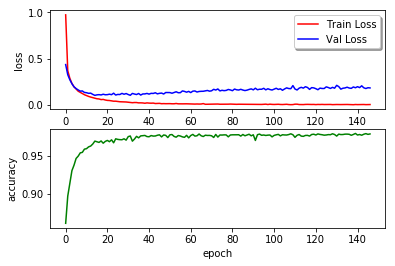

EPOCH: 148
TRAIN LOSS: 0.0043311490316406635
VAL LOSS: 0.1895565292321121
VAL ACCURACY: 97.7 %
TIME: 306.3 s


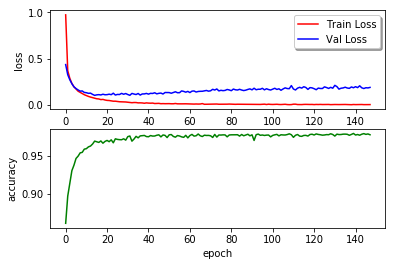

EPOCH: 149
TRAIN LOSS: 0.007938919086330801
VAL LOSS: 0.21059411593347185
VAL ACCURACY: 97.5 %
TIME: 307.3 s


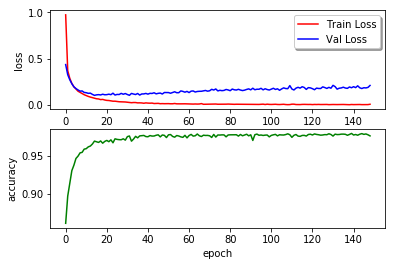

EPOCH: 150
TRAIN LOSS: 0.0051632814258666575
VAL LOSS: 0.18789789765993964
VAL ACCURACY: 97.9 %
TIME: 307.8 s


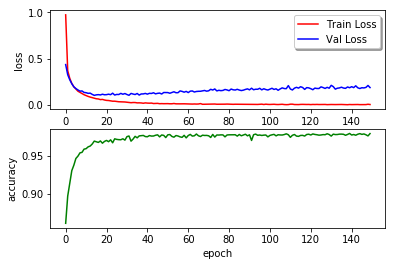

EPOCH: 151
TRAIN LOSS: 0.0035970707590233797
VAL LOSS: 0.19281628004231244
VAL ACCURACY: 97.7 %
TIME: 305.2 s


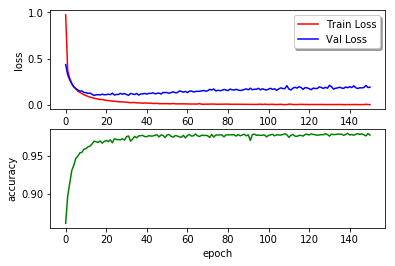

EPOCH: 152
TRAIN LOSS: 0.004112544991098004
VAL LOSS: 0.1736221603722421
VAL ACCURACY: 97.9 %
TIME: 303.3 s


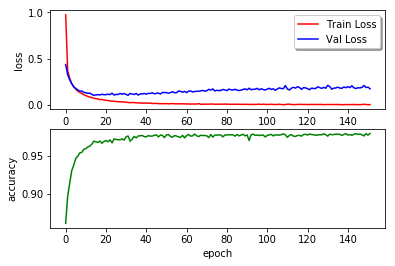

EPOCH: 153
TRAIN LOSS: 0.004173130289590088
VAL LOSS: 0.17670814481792632
VAL ACCURACY: 97.7 %
TIME: 306.2 s


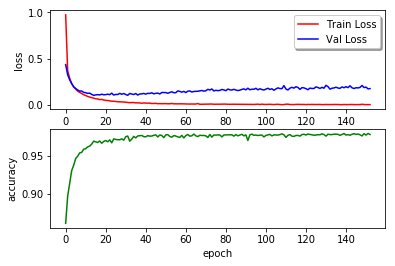

EPOCH: 154
TRAIN LOSS: 0.0032157948083220205
VAL LOSS: 0.19334719968548658
VAL ACCURACY: 97.7 %
TIME: 305.4 s


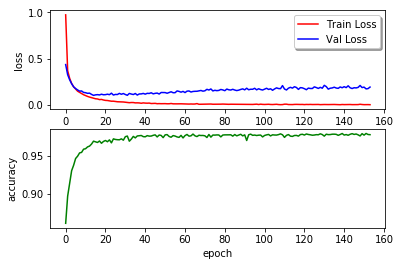

EPOCH: 155
TRAIN LOSS: 0.004133054564863708
VAL LOSS: 0.17710563632772425
VAL ACCURACY: 97.7 %
TIME: 307.2 s


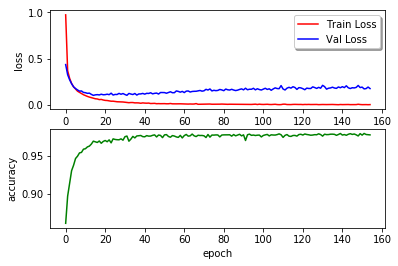

EPOCH: 156
TRAIN LOSS: 0.005198302500740949
VAL LOSS: 0.1907540363598095
VAL ACCURACY: 97.7 %
TIME: 306.3 s


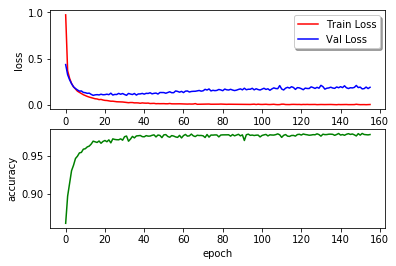

EPOCH: 157
TRAIN LOSS: 0.0040703643752899475
VAL LOSS: 0.1875156495007586
VAL ACCURACY: 97.9 %
TIME: 303.3 s


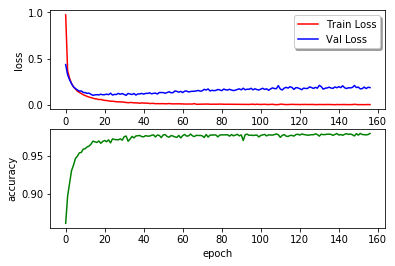

EPOCH: 158
TRAIN LOSS: 0.004247301048236324
VAL LOSS: 0.17087181578616223
VAL ACCURACY: 97.8 %
TIME: 309.3 s


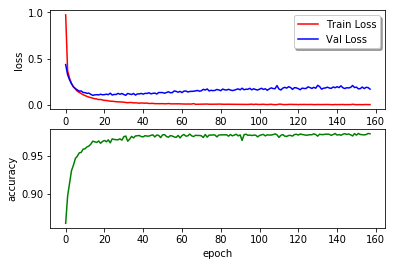

EPOCH: 159
TRAIN LOSS: 0.003446062563172034
VAL LOSS: 0.172258863835825
VAL ACCURACY: 97.8 %
TIME: 306.0 s


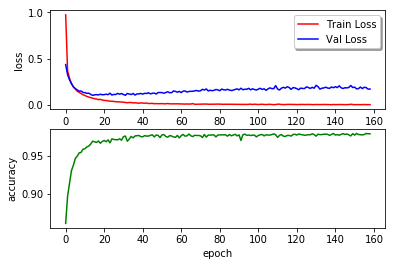

EPOCH: 160
TRAIN LOSS: 0.0026047502402516327
VAL LOSS: 0.20763405533205445
VAL ACCURACY: 97.7 %
TIME: 306.3 s


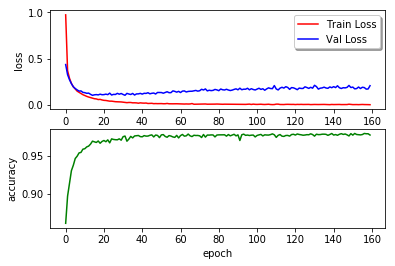

EPOCH: 161
TRAIN LOSS: 0.005283983219587107
VAL LOSS: 0.1865318248677571
VAL ACCURACY: 97.8 %
TIME: 305.3 s


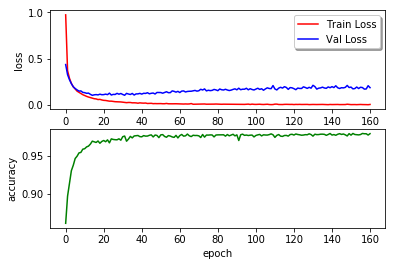

EPOCH: 162
TRAIN LOSS: 0.004339662794123438
VAL LOSS: 0.1948759952068303
VAL ACCURACY: 97.6 %
TIME: 306.4 s


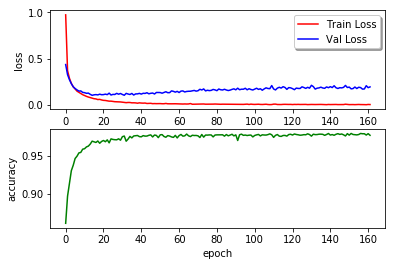

EPOCH: 163
TRAIN LOSS: 0.003377861512241201
VAL LOSS: 0.19662775273601032
VAL ACCURACY: 97.8 %
TIME: 310.5 s


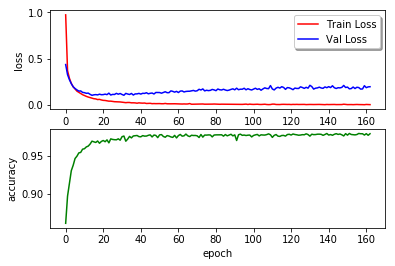

EPOCH: 164
TRAIN LOSS: 0.005134609151379903
VAL LOSS: 0.19387944276913352
VAL ACCURACY: 97.7 %
TIME: 306.9 s


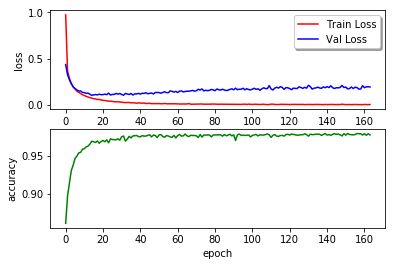

EPOCH: 165
TRAIN LOSS: 0.005093390079525922
VAL LOSS: 0.15578716669033088
VAL ACCURACY: 97.9 %
TIME: 307.8 s


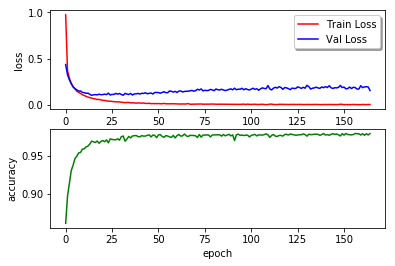

EPOCH: 166
TRAIN LOSS: 0.002946830637780937
VAL LOSS: 0.1758399718758834
VAL ACCURACY: 97.9 %
TIME: 309.2 s


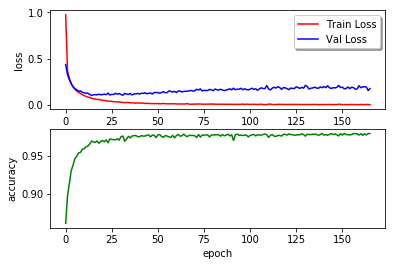

EPOCH: 167
TRAIN LOSS: 0.0028370987631119015
VAL LOSS: 0.18271146106397737
VAL ACCURACY: 97.9 %
TIME: 306.1 s


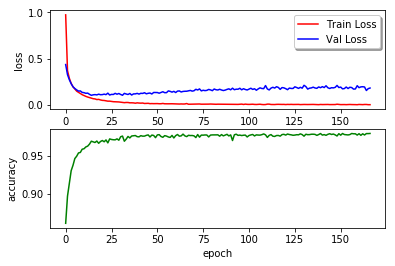

EPOCH: 168
TRAIN LOSS: 0.003983827811230972
VAL LOSS: 0.1771477829288775
VAL ACCURACY: 97.8 %
TIME: 309.9 s


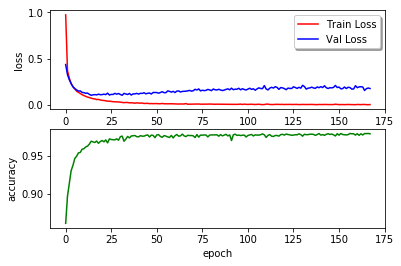

EPOCH: 169
TRAIN LOSS: 0.004331187400311954
VAL LOSS: 0.21640726594125337
VAL ACCURACY: 97.5 %
TIME: 306.7 s


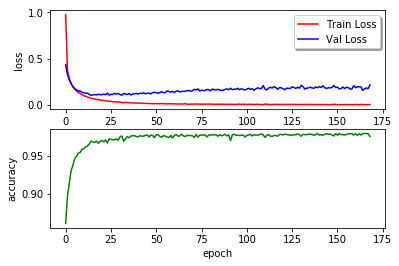

EPOCH: 170
TRAIN LOSS: 0.005173707655436794
VAL LOSS: 0.18255480658812245
VAL ACCURACY: 97.7 %
TIME: 309.2 s


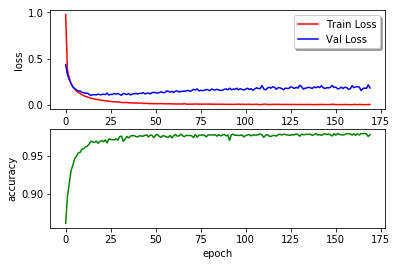

EPOCH: 171
TRAIN LOSS: 0.0035429940020055705
VAL LOSS: 0.1905774427329598
VAL ACCURACY: 97.8 %
TIME: 308.2 s


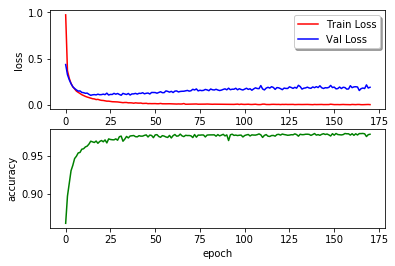

EPOCH: 172
TRAIN LOSS: 0.003156868172203928
VAL LOSS: 0.18249903958899705
VAL ACCURACY: 97.9 %
TIME: 308.2 s


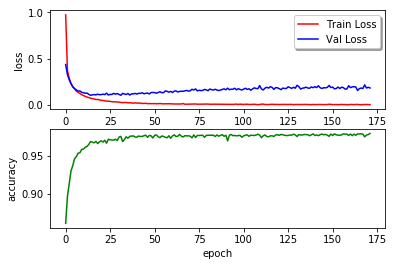

EPOCH: 173
TRAIN LOSS: 0.004188802907960277
VAL LOSS: 0.21651763177215816
VAL ACCURACY: 97.8 %
TIME: 307.7 s


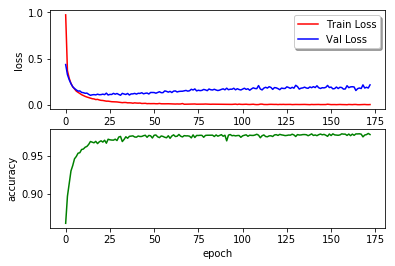

EPOCH: 174
TRAIN LOSS: 0.0035926703921048014
VAL LOSS: 0.18831520027072696
VAL ACCURACY: 97.9 %
TIME: 303.4 s


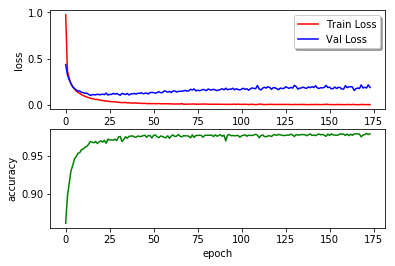

EPOCH: 175
TRAIN LOSS: 0.004365375139954566
VAL LOSS: 0.19926798889278352
VAL ACCURACY: 97.7 %
TIME: 307.5 s


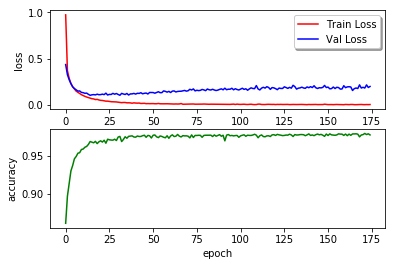

EPOCH: 176
TRAIN LOSS: 0.003441206282604548
VAL LOSS: 0.1945468805562227
VAL ACCURACY: 97.8 %
TIME: 307.6 s


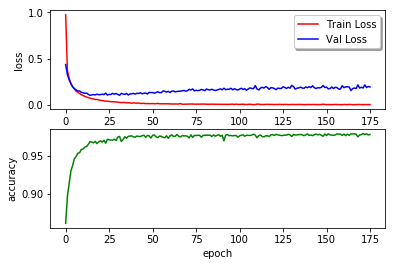

EPOCH: 177
TRAIN LOSS: 0.004141556957479144
VAL LOSS: 0.19914866437737158
VAL ACCURACY: 97.7 %
TIME: 311.4 s


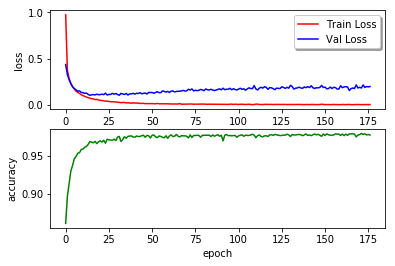

EPOCH: 178
TRAIN LOSS: 0.002978939668160468
VAL LOSS: 0.19946156306370666
VAL ACCURACY: 97.8 %
TIME: 306.7 s


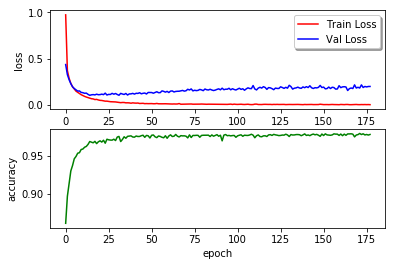

EPOCH: 179
TRAIN LOSS: 0.003606990489896702
VAL LOSS: 0.2144425132697069
VAL ACCURACY: 97.7 %
TIME: 308.2 s


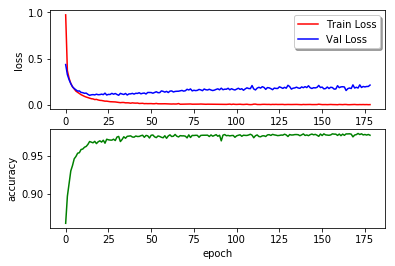

EPOCH: 180
TRAIN LOSS: 0.003953720151495805
VAL LOSS: 0.206750003331588
VAL ACCURACY: 97.7 %
TIME: 307.5 s


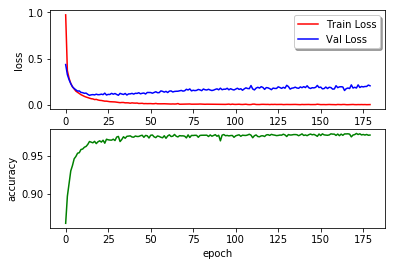

EPOCH: 181
TRAIN LOSS: 0.0033866855465562585
VAL LOSS: 0.22265497883439966
VAL ACCURACY: 97.7 %
TIME: 306.4 s


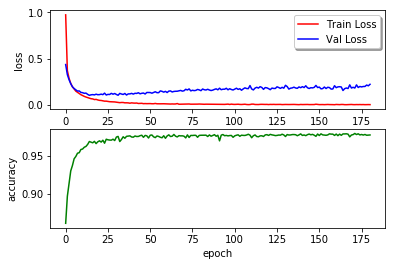

EPOCH: 182
TRAIN LOSS: 0.0031389853019530845
VAL LOSS: 0.19207888454325653
VAL ACCURACY: 97.8 %
TIME: 312.0 s


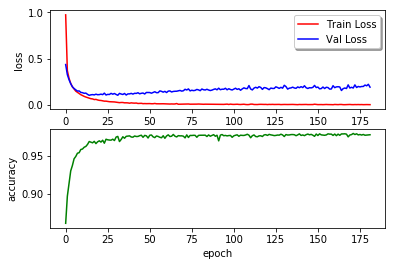

EPOCH: 183
TRAIN LOSS: 0.0031710599797690527
VAL LOSS: 0.20166198457804754
VAL ACCURACY: 97.9 %
TIME: 308.8 s


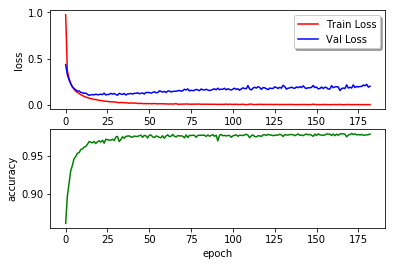

EPOCH: 184
TRAIN LOSS: 0.003103770785103194
VAL LOSS: 0.19463520289641956
VAL ACCURACY: 97.8 %
TIME: 307.8 s


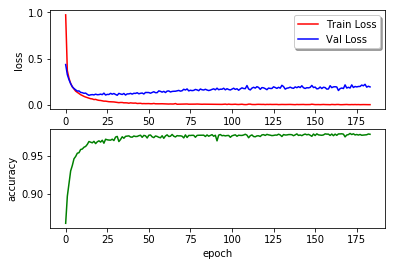

EPOCH: 185
TRAIN LOSS: 0.003179651228097571
VAL LOSS: 0.19860678821437716
VAL ACCURACY: 98.0 %
TIME: 306.2 s


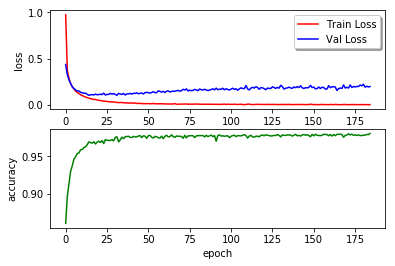

EPOCH: 186
TRAIN LOSS: 0.003987141847886113
VAL LOSS: 0.20444822615511898
VAL ACCURACY: 97.7 %
TIME: 307.9 s


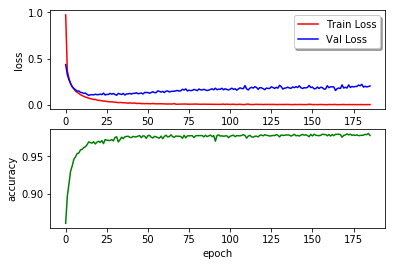

EPOCH: 187
TRAIN LOSS: 0.002906458250189471
VAL LOSS: 0.19904042059429258
VAL ACCURACY: 97.8 %
TIME: 308.1 s


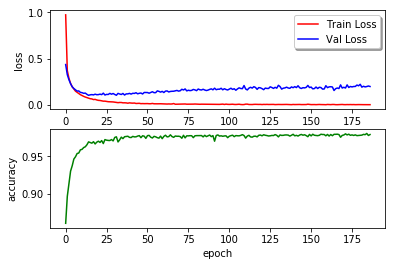

EPOCH: 188
TRAIN LOSS: 0.002595451654641676
VAL LOSS: 0.1955029029086998
VAL ACCURACY: 97.9 %
TIME: 308.1 s


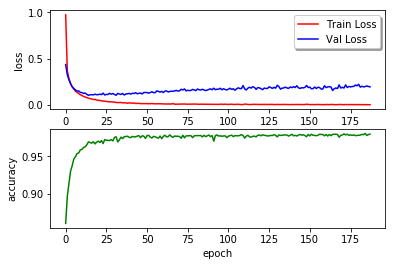

EPOCH: 189
TRAIN LOSS: 0.0036059588588520106
VAL LOSS: 0.2033873163583795
VAL ACCURACY: 97.8 %
TIME: 311.2 s


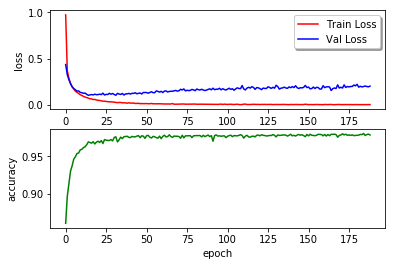

EPOCH: 190
TRAIN LOSS: 0.005302951437676649
VAL LOSS: 0.20964311565216665
VAL ACCURACY: 97.8 %
TIME: 307.4 s


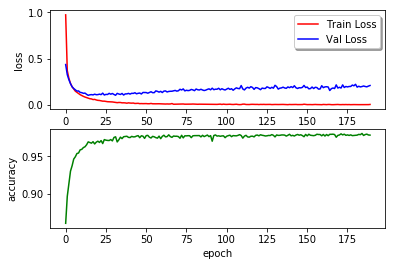

EPOCH: 191
TRAIN LOSS: 0.003511027006416203
VAL LOSS: 0.20122876331398562
VAL ACCURACY: 97.8 %
TIME: 309.7 s


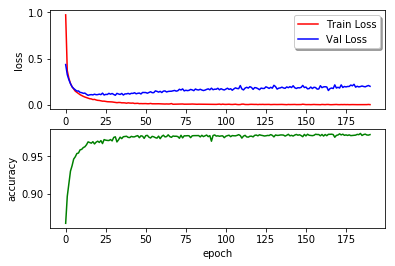

EPOCH: 192
TRAIN LOSS: 0.004037269258199499
VAL LOSS: 0.19931383814171758
VAL ACCURACY: 97.7 %
TIME: 306.4 s


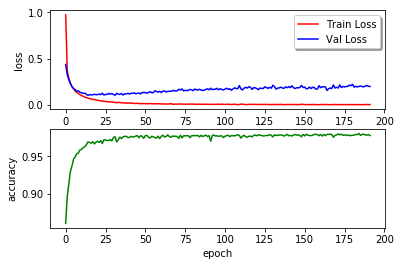

EPOCH: 193
TRAIN LOSS: 0.002265503635205831
VAL LOSS: 0.2102189561012555
VAL ACCURACY: 97.6 %
TIME: 309.8 s


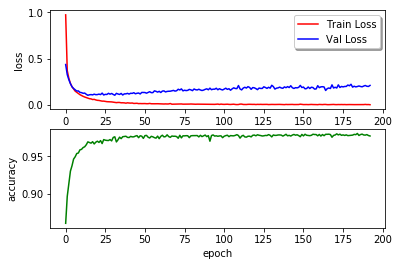

EPOCH: 194
TRAIN LOSS: 0.003708309331708298
VAL LOSS: 0.2080066298989724
VAL ACCURACY: 97.7 %
TIME: 308.9 s


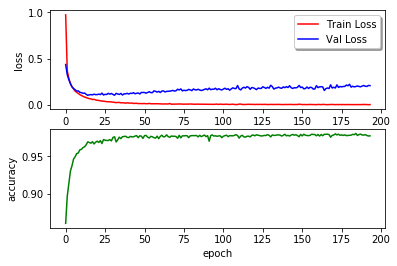

EPOCH: 195
TRAIN LOSS: 0.0032345925928592783
VAL LOSS: 0.19298450341167506
VAL ACCURACY: 97.7 %
TIME: 304.3 s


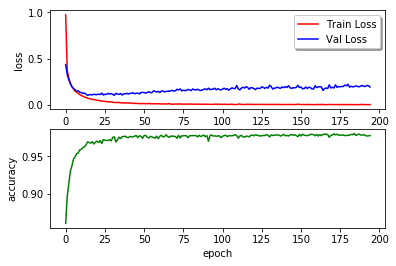

EPOCH: 196
TRAIN LOSS: 0.004529695719502305
VAL LOSS: 0.20803374545330022
VAL ACCURACY: 97.7 %
TIME: 309.9 s


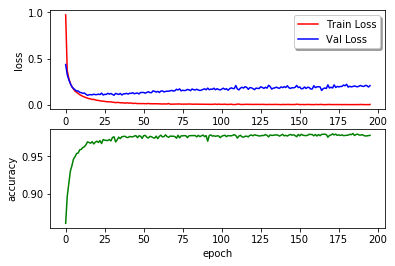

EPOCH: 197
TRAIN LOSS: 0.0035693574736526115
VAL LOSS: 0.23517951660715436
VAL ACCURACY: 97.8 %
TIME: 303.8 s


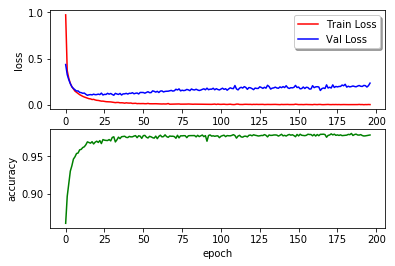

EPOCH: 198
TRAIN LOSS: 0.004077726753552118
VAL LOSS: 0.2130235383602433
VAL ACCURACY: 97.7 %
TIME: 308.6 s


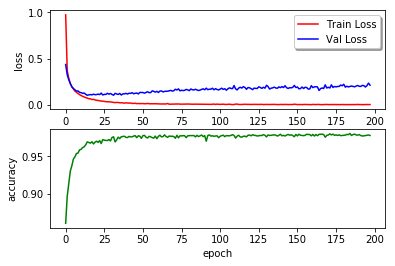

EPOCH: 199
TRAIN LOSS: 0.003545881323189131
VAL LOSS: 0.20818456878637073
VAL ACCURACY: 97.8 %
TIME: 306.9 s


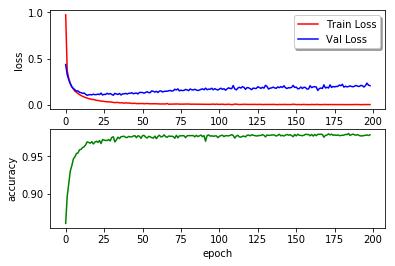

EPOCH: 200
TRAIN LOSS: 0.0023306336943125093
VAL LOSS: 0.20759173639912817
VAL ACCURACY: 97.8 %
TIME: 307.2 s


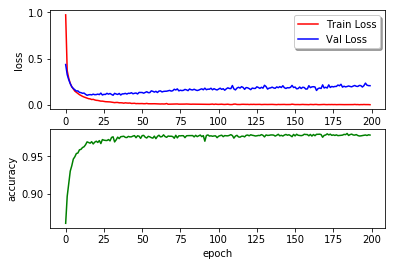

EPOCH: 201
TRAIN LOSS: 0.0024800609159790097
VAL LOSS: 0.2072030135695012
VAL ACCURACY: 97.9 %
TIME: 306.2 s


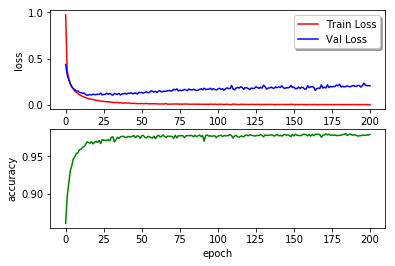

EPOCH: 202
TRAIN LOSS: 0.0023641768469072465
VAL LOSS: 0.23540147745003326
VAL ACCURACY: 97.7 %
TIME: 305.9 s


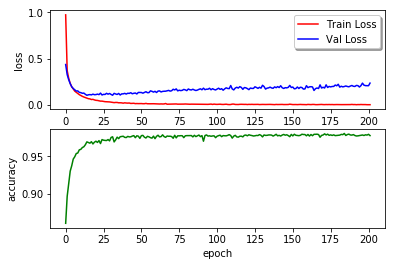

EPOCH: 203
TRAIN LOSS: 0.00561877490005268
VAL LOSS: 0.20627186142278356
VAL ACCURACY: 97.6 %
TIME: 305.6 s


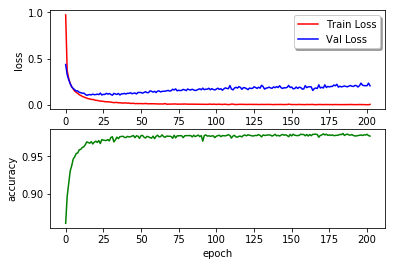

EPOCH: 204
TRAIN LOSS: 0.004661252521909711
VAL LOSS: 0.19115115528949345
VAL ACCURACY: 97.6 %
TIME: 306.4 s


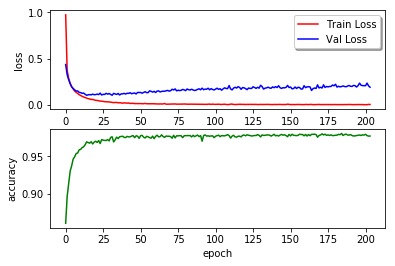

EPOCH: 205
TRAIN LOSS: 0.0024747180519496415
VAL LOSS: 0.18301035153022482
VAL ACCURACY: 97.8 %
TIME: 307.7 s


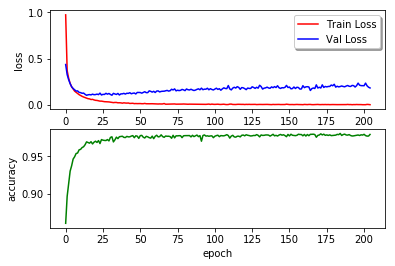

EPOCH: 206
TRAIN LOSS: 0.0040580401565707335
VAL LOSS: 0.21043536111713135
VAL ACCURACY: 97.8 %
TIME: 309.1 s


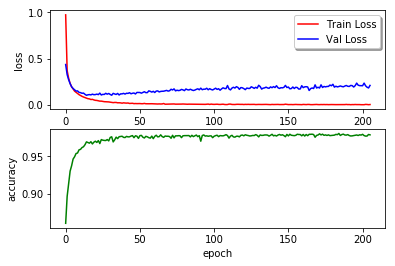

EPOCH: 207
TRAIN LOSS: 0.003683116027342127
VAL LOSS: 0.20400331749547948
VAL ACCURACY: 97.8 %
TIME: 499.3 s


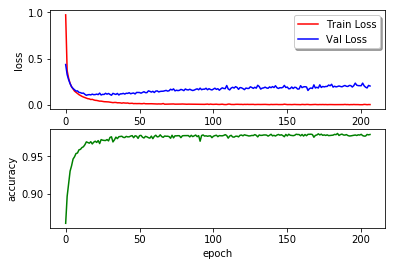

EPOCH: 208
TRAIN LOSS: 0.002885001022826467
VAL LOSS: 0.19375310279324934
VAL ACCURACY: 97.8 %
TIME: 2501.5 s


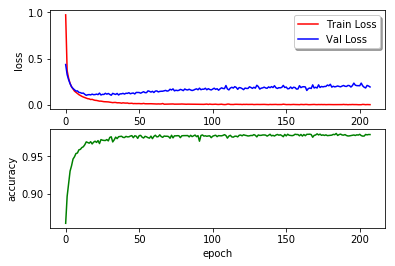

EPOCH: 209
TRAIN LOSS: 0.0014315027442474402
VAL LOSS: 0.22927713367534355
VAL ACCURACY: 97.7 %
TIME: 1131.1 s


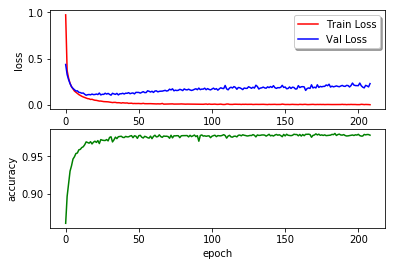

EPOCH: 210
TRAIN LOSS: 0.004043785018123334
VAL LOSS: 0.2044987136551384
VAL ACCURACY: 97.7 %
TIME: 461.1 s


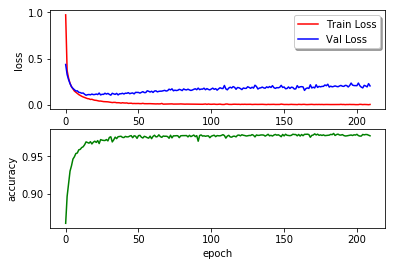

EPOCH: 211
TRAIN LOSS: 0.003916562809333941
VAL LOSS: 0.19140869515724707
VAL ACCURACY: 97.7 %
TIME: 442.9 s


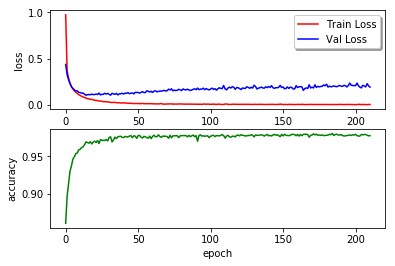

EPOCH: 212
TRAIN LOSS: 0.003167259673004308
VAL LOSS: 0.19484418628663414
VAL ACCURACY: 97.7 %
TIME: 471.9 s


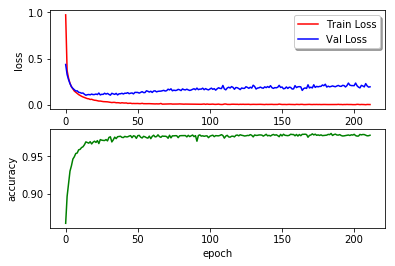

EPOCH: 213
TRAIN LOSS: 0.003015727283869209
VAL LOSS: 0.19071261848335144
VAL ACCURACY: 97.9 %
TIME: 459.9 s


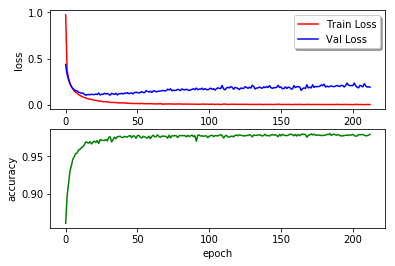

EPOCH: 214
TRAIN LOSS: 0.003239299345865612
VAL LOSS: 0.19976449136213964
VAL ACCURACY: 97.9 %
TIME: 454.0 s


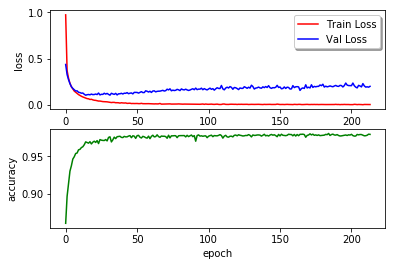

EPOCH: 215
TRAIN LOSS: 0.0034577823609896214
VAL LOSS: 0.19377578210308624
VAL ACCURACY: 97.7 %
TIME: 438.6 s


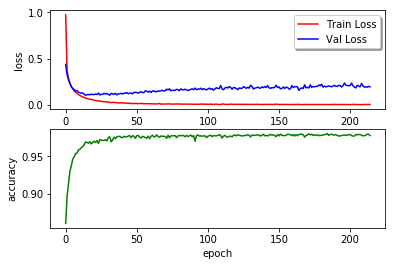

EPOCH: 216
TRAIN LOSS: 0.0027515581738192527
VAL LOSS: 0.20032204215567845
VAL ACCURACY: 97.8 %
TIME: 456.3 s


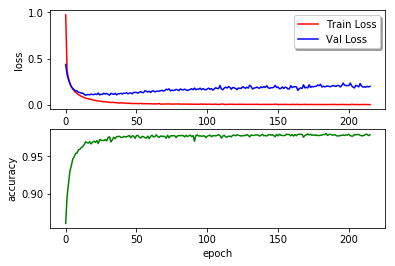

EPOCH: 217
TRAIN LOSS: 0.0025929249536519
VAL LOSS: 0.21157224080088238
VAL ACCURACY: 97.7 %
TIME: 464.6 s


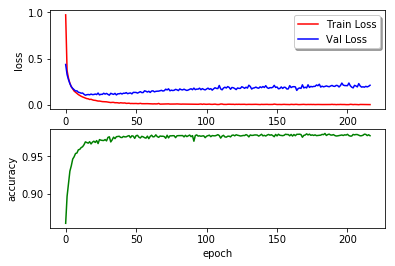

EPOCH: 218
TRAIN LOSS: 0.004413309491017125
VAL LOSS: 0.1859057321260618
VAL ACCURACY: 97.7 %
TIME: 454.9 s


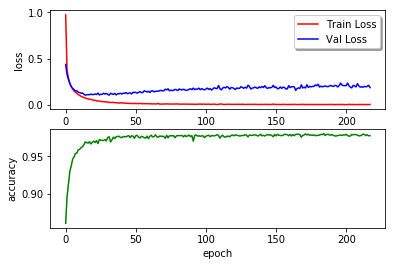

KeyboardInterrupt: 

In [15]:
import time
import sklearn
import numpy 
import matplotlib.pyplot as plt
import numpy as np
###################### TRAINING #########################
print ("START TRAINING...")
train_loss = []
val_loss = []
val_accuracy = []
for epoch in range(1,450):
 
    #start timer
    start = time.time()
    
    #reset confusion matrix
    #clearConfusionMatrix()
 
    #iterate over train split batches and calculate mean loss for epoch
    t_l = []
    for image_batch, target_batch in getNextImageBatch():
 
        #calling the training functions returns the current loss
        l = train_net(image_batch, target_batch)
        t_l.append(l)
 
    #we validate our net every epoch and pass our validation split through as well
    v_l = []
    v_a = []
    for image_batch, target_batch in getNextImageBatch(VAL):
  
        #calling the test function returns the net output, loss and accuracy
        prediction_batch, l, a = test_net(image_batch, target_batch)
        v_l.append(l)
        v_a.append(a)
         
        #save predicions and targets for confusion matrix
        
        #updateConfusionMatrix(target_batch,prediction_batch)
    
    #mlxtend confusion matrix
    #cm=confusion_matrix(target_batch,prediction_batch)
    #    fig,ax=plot_confusion_matrix(conf_mat=cm)
      #  plt.show()
        
        #pandas_ml confusion matrix
        #confusion_matrix1 = ConfusionMatrix(target_batch,prediction_batch)
        #print("Confusion matrix:\n%s" % confusion_matrix1)
        
    #stop timer
    end = time.time()
 
    #calculate stats for epoch
    train_loss.append(np.mean(t_l))
    val_loss.append(np.mean(v_l))
    val_accuracy.append(np.mean(v_a))
 
    #print stats for epoch
    print ("EPOCH:", epoch,)
    print ("TRAIN LOSS:", train_loss[-1],)
    print ("VAL LOSS:", val_loss[-1],)
    print ("VAL ACCURACY:", (int(val_accuracy[-1] * 1000) / 10.0), "%",)
    print ("TIME:", (int((end - start) * 10) / 10.0), "s")
 
    #show chart
    showChart(epoch, train_loss, val_loss, val_accuracy)
    
    #show confusion matrix
    #showConfusionMatrix()

    #show best accuracy and epoch
print ("BEST VAL ACCURACY:", (int(max(val_accuracy) * 1000) / 10.0), "%", "EPOCH:", val_accuracy.index(max(val_accuracy)) + 1)

#####TESTING DATA#######
test_err = 0
test_acc = 0
test_batches = 0
for image_batch, target_batch in getNextImageBatch1():
    test_batch, err, acc = test_net(image_batch, target_batch)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))
print ("TRAINING DONE!") 

In [73]:
 
    #first convolutional layer, has l_input layer as incoming and is followed by a pooling layer
    l_conv1 = layers.Conv2DLayer(l_input, num_filters=32, filter_size=3, nonlinearity=lasagne.nonlinearities.rectify)
    
    #l_pool = layers.MaxPool2DLayer(l_conv1, pool_size=2)
    
    l_drop1= layers.DropoutLayer(l_conv1,  p=0.1)
    
    #l_dense1 = layers.DenseLayer(l_drop1, num_units=128)
    
    #l_conv2 = layers.Conv2DLayer(l_drop1, num_filters=128, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
   
    #l_conv3 = layers.Conv2DLayer(l_conv2, num_filters=256, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_dense2 = layers.DenseLayer(l_drop1, num_units=128)
    
    l_drop2= layers.DropoutLayer(l_dense2,  p=0.25)
    
    l_dense2 = layers.DenseLayer(l_drop2, num_units=128)
    
    l_output = layers.DenseLayer(l_dense2, num_units=7, nonlinearity=lasagne.nonlinearities.softmax)
    
    #let's see how many params our net has
    print ("MODEL HAS", layers.count_params(l_output), "PARAMS")
    

array([1., 1., 1., 1., 1., 1., 1.])

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1],
                      title='Confusion matrix')